Imports & Global Settings

In [2]:
import os
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# For reproducible layouts
np.random.seed(42)

# Set base directories relative to the current working directory (assumes notebook is run from project root)
BASE_DIR = "/Users/tanishqsingh/Documents/GitHub/Scene_Graph_1"
DATA_DIR = os.path.join(BASE_DIR, "data")
FRAMES_DIR = os.path.join(BASE_DIR, "frames")
MODELS_DIR = os.path.join(BASE_DIR, "models")

# Create necessary directories if they don't exist
for folder in [FRAMES_DIR]:
    if not os.path.exists(folder):
        os.makedirs(folder)

Frame Extraction from Video

In [3]:
def extract_frames(video_path, frames_dir, sample_rate=5):
    """
    Extract frames from a video and save them as images.
    
    Args:
        video_path (str): Path to the input video.
        frames_dir (str): Directory to save the frames.
        sample_rate (int): Save every nth frame.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Error: Could not open video file at " + video_path)
    
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % sample_rate == 0:
            frame_filename = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames from the video.")

# Run frame extraction
video_file = os.path.join(DATA_DIR, "input_video.mp4")
extract_frames(video_file, FRAMES_DIR, sample_rate=5)

Extracted 110 frames from the video.


YOLO Object Detection Setup

In [4]:
# Paths to YOLO files (ensure these files are in the models folder)
yolo_cfg = os.path.join(MODELS_DIR, "yolov3.cfg")
yolo_weights = os.path.join(MODELS_DIR, "yolov3.weights")
yolo_names = os.path.join(MODELS_DIR, "coco.names")

# Load class names
with open(yolo_names, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load YOLO network using OpenCV's DNN module
net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Determine output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

Simple Centroid Tracker

In [5]:
class CentroidTracker:
    def __init__(self, max_disappeared=50):
        self.nextObjectID = 0
        self.objects = {}  # Maps object IDs to {'centroid': (x, y), 'bbox': [x,y,w,h], 'label': str}
        self.disappeared = {}
        self.max_disappeared = max_disappeared

    def register(self, centroid, bbox, label):
        self.objects[self.nextObjectID] = {"centroid": centroid, "bbox": bbox, "label": label}
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]

    def update(self, detections):
        """
        Update tracker with new detections.
        
        Args:
            detections (list of tuples): Each tuple is (bbox, label)
                where bbox = [x, y, w, h]
        Returns:
            objects (dict): Dictionary of current objects with their IDs.
        """
        if len(detections) == 0:
            # Mark existing objects as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)
            return self.objects

        # Compute centroids for new detections
        input_centroids = []
        for bbox, _ in detections:
            x, y, w, h = bbox
            cX = int(x + w / 2)
            cY = int(y + h / 2)
            input_centroids.append((cX, cY))
        
        # If there are no existing objects, register all detections.
        if len(self.objects) == 0:
            for i, detection in enumerate(detections):
                self.register(input_centroids[i], detection[0], detection[1])
        else:
            # Get current object IDs and centroids
            objectIDs = list(self.objects.keys())
            object_centroids = [self.objects[objectID]["centroid"] for objectID in objectIDs]

            # Compute distance matrix between old and new centroids.
            D = np.linalg.norm(np.array(object_centroids)[:, np.newaxis] - np.array(input_centroids), axis=2)

            # Find the smallest distances and sort them
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows = set()
            used_cols = set()

            # Match object IDs with new detections.
            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue
                objectID = objectIDs[row]
                self.objects[objectID]["centroid"] = input_centroids[col]
                self.objects[objectID]["bbox"] = detections[col][0]
                self.objects[objectID]["label"] = detections[col][1]
                self.disappeared[objectID] = 0

                used_rows.add(row)
                used_cols.add(col)

            # For unmatched old objects, mark them as disappeared.
            unused_rows = set(range(0, D.shape[0])).difference(used_rows)
            for row in unused_rows:
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)
            
            # Register new detections that weren't matched.
            unused_cols = set(range(0, D.shape[1])).difference(used_cols)
            for col in unused_cols:
                self.register(input_centroids[col], detections[col][0], detections[col][1])

        return self.objects

# Instantiate the tracker
tracker = CentroidTracker(max_disappeared=20)

Object Detection Function (YOLO)

In [6]:
def detect_objects(image, conf_threshold=0.5, nms_threshold=0.4):
    """
    Perform object detection using YOLO on a single image.
    
    Returns:
        filtered_boxes (list): Bounding boxes [x, y, w, h].
        filtered_labels (list): Class labels for each detection.
    """
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    for output in outs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # Apply Non-Maximum Suppression to reduce overlapping boxes.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    filtered_boxes = []
    filtered_labels = []
    for i in indices:
        i = i[0] if isinstance(i, (list, tuple, np.ndarray)) else i
        filtered_boxes.append(boxes[i])
        filtered_labels.append(classes[class_ids[i]])
    
    return filtered_boxes, filtered_labels

Relationship Detection (Fully Implemented Dummy)

In [7]:
def detect_relationships(detected_objects, distance_threshold=100):
    """
    Determine simple spatial relationships between objects.
    If two objects’ centers are closer than distance_threshold, we label their relationship as "next to".
    
    Args:
        detected_objects (list of dict): Each dict should contain keys 'id', 'bbox', 'label'.
        
    Returns:
        relationships (list of dict): Each dict has keys:
            - subject_id
            - object_id
            - predicate (e.g., "next to")
    """
    relationships = []
    num_objects = len(detected_objects)
    
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            bbox1 = detected_objects[i]["bbox"]
            bbox2 = detected_objects[j]["bbox"]
            
            # Compute center points for each bounding box.
            c1 = (bbox1[0] + bbox1[2] // 2, bbox1[1] + bbox1[3] // 2)
            c2 = (bbox2[0] + bbox2[2] // 2, bbox2[1] + bbox2[3] // 2)
            distance = np.linalg.norm(np.array(c1) - np.array(c2))
            
            if distance < distance_threshold:
                relationships.append({
                    "subject_id": detected_objects[i]["id"],
                    "object_id": detected_objects[j]["id"],
                    "predicate": "next to"
                })
    return relationships

Scene Graph Construction & Visualization

In [8]:
def build_scene_graph(objects, relationships):
    """
    Build a directed scene graph using NetworkX.
    
    Args:
        objects (dict): Mapping from object ID to object info (label, bbox).
        relationships (list): List of relationship dictionaries.
        
    Returns:
        G (networkx.DiGraph): The constructed scene graph.
    """
    G = nx.DiGraph()
    
    # Add each object as a node.
    for obj_id, info in objects.items():
        G.add_node(obj_id, label=info["label"], bbox=info["bbox"])
    
    # Add relationships as edges.
    for rel in relationships:
        subj = rel["subject_id"]
        obj = rel["object_id"]
        predicate = rel["predicate"]
        G.add_edge(subj, obj, predicate=predicate)
    
    return G

def visualize_scene_graph(G, title="Scene Graph"):
    """
    Visualize a scene graph using matplotlib.
    """
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G, seed=42)
    
    # Prepare node labels (ID:Label)
    node_labels = {n: f"{n}:{G.nodes[n]['label']}" for n in G.nodes()}
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    
    # Draw directed edges with relationship labels.
    edge_labels = nx.get_edge_attributes(G, "predicate")
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(title)
    plt.axis("off")
    plt.show()

Process Frames, Build & Aggregate Scene Graphs

Scene Graph for frame_00000.jpg


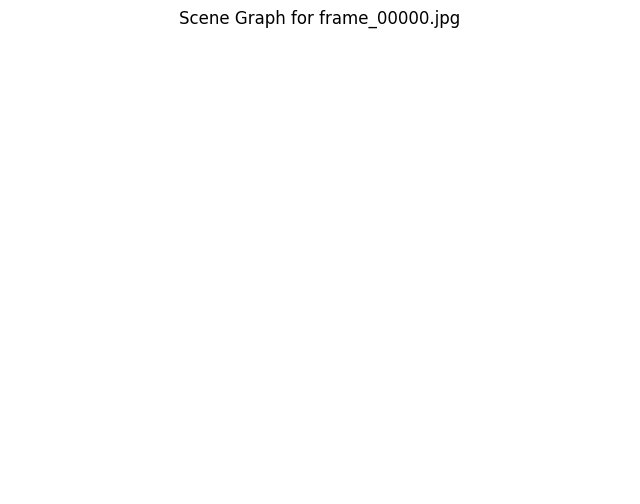

Scene Graph for frame_00005.jpg


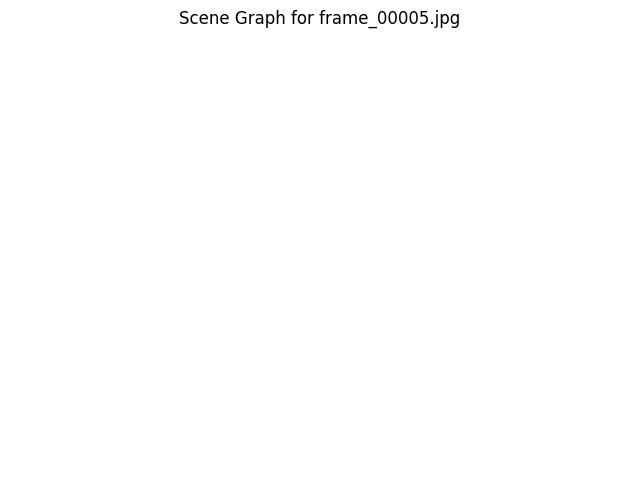

Scene Graph for frame_00010.jpg


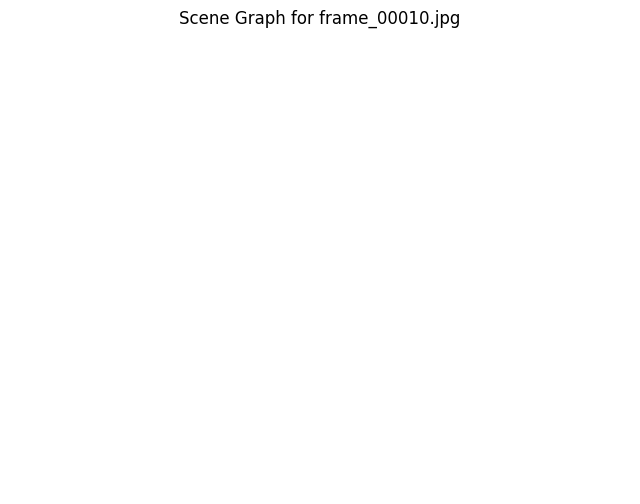

Scene Graph for frame_00015.jpg


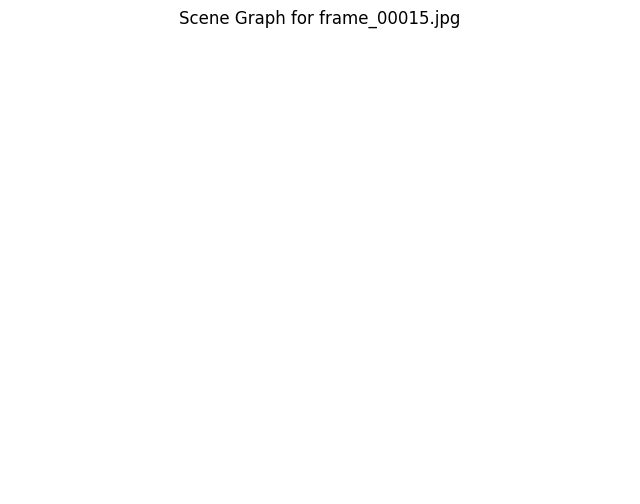

Scene Graph for frame_00020.jpg


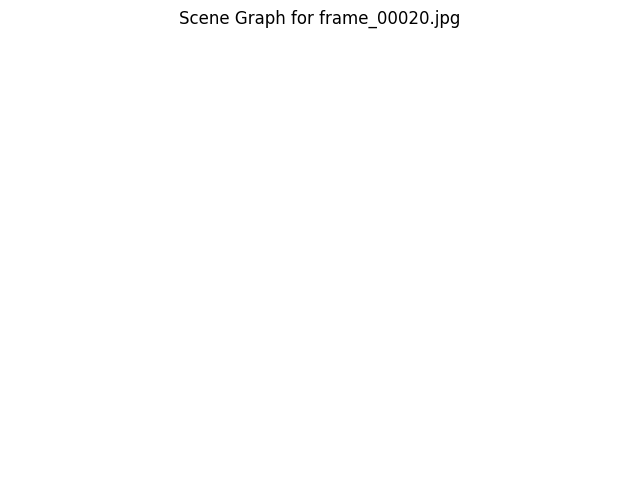

Scene Graph for frame_00025.jpg


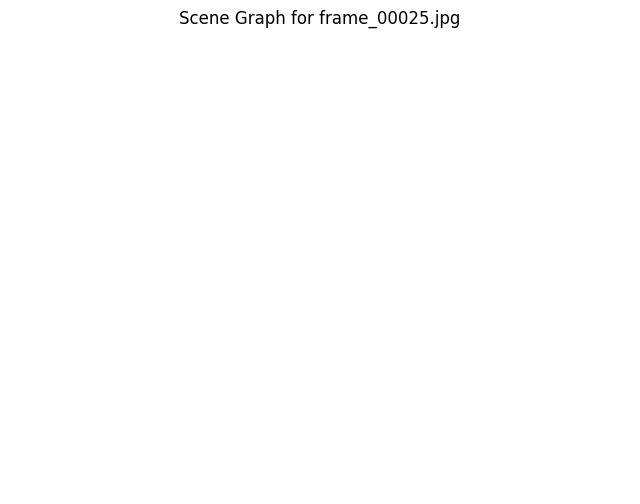

Scene Graph for frame_00030.jpg


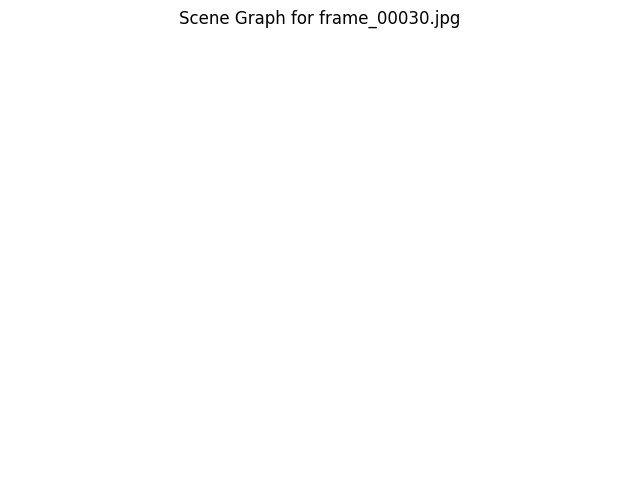

Scene Graph for frame_00035.jpg


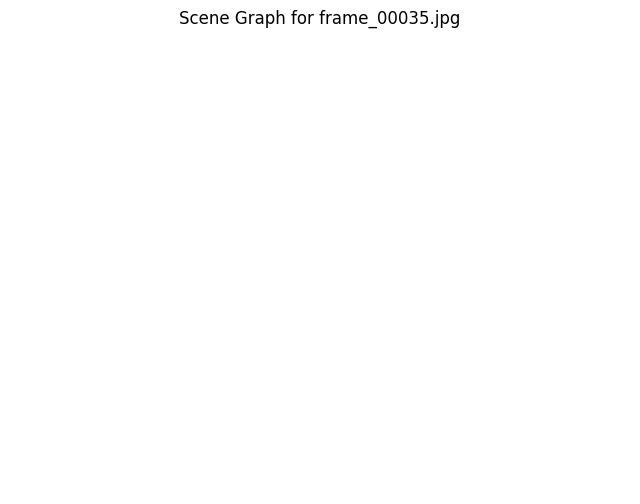

Scene Graph for frame_00040.jpg


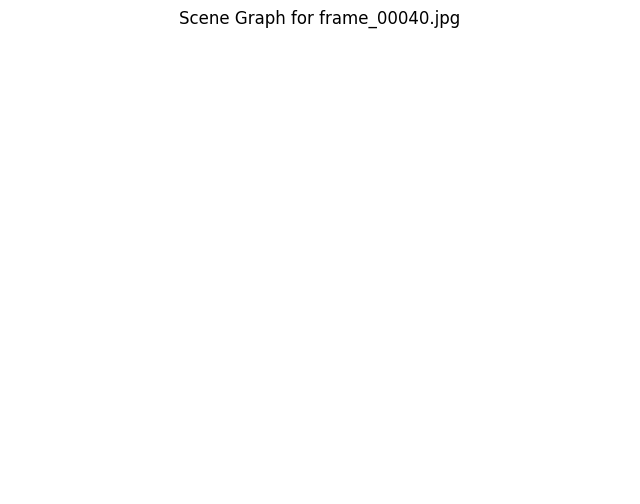

Scene Graph for frame_00045.jpg


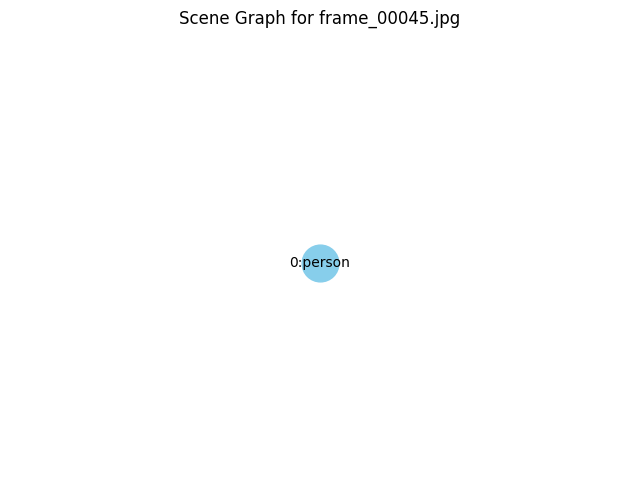

Scene Graph for frame_00050.jpg


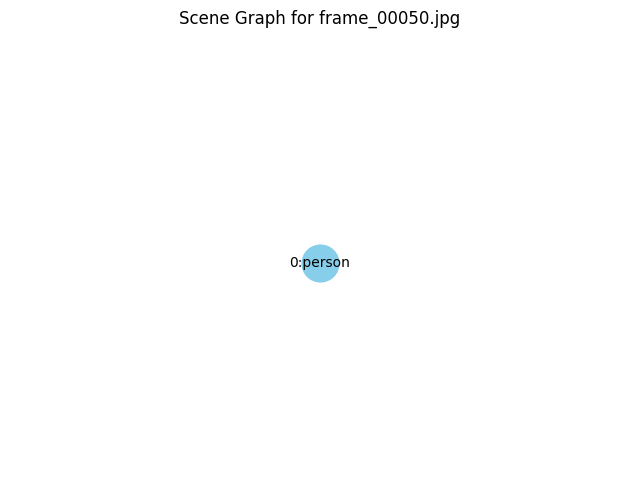

Scene Graph for frame_00055.jpg


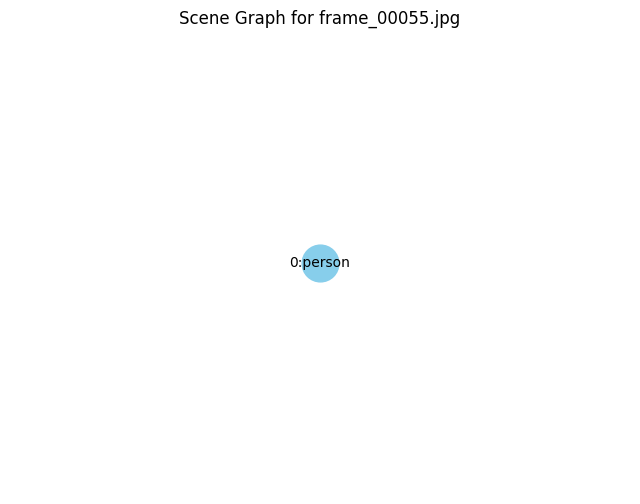

Scene Graph for frame_00060.jpg


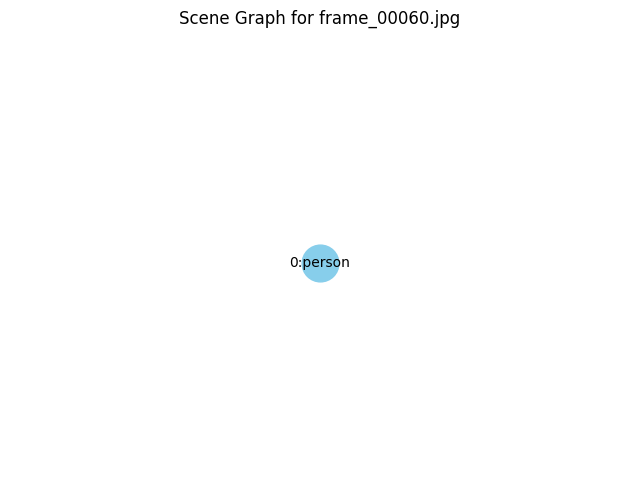

Scene Graph for frame_00065.jpg


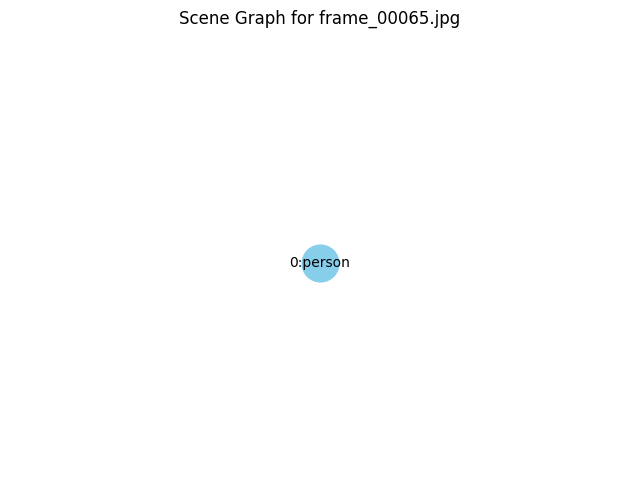

Scene Graph for frame_00070.jpg


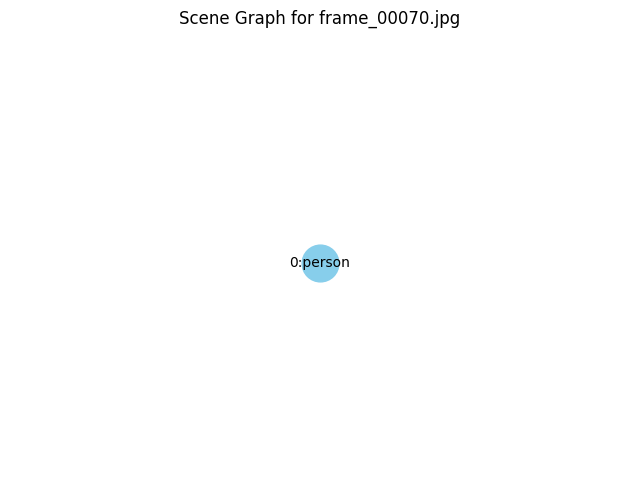

Scene Graph for frame_00075.jpg


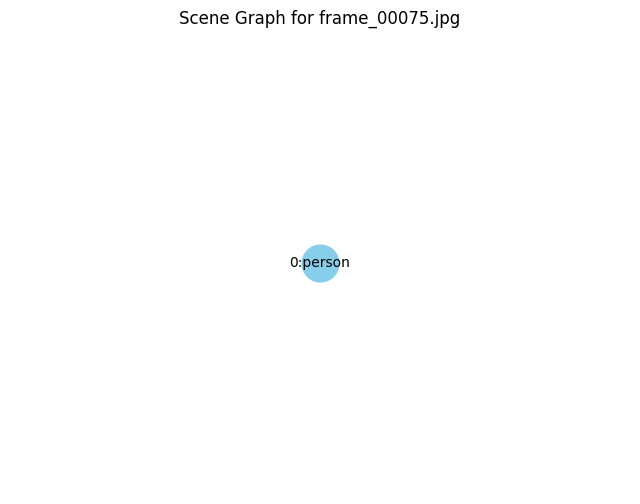

Scene Graph for frame_00080.jpg


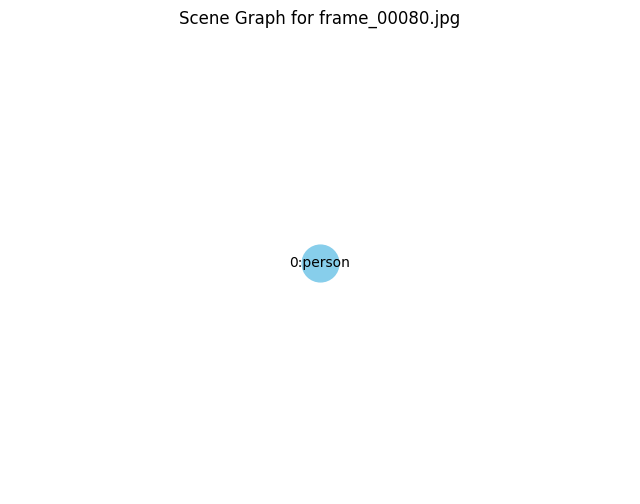

Scene Graph for frame_00085.jpg


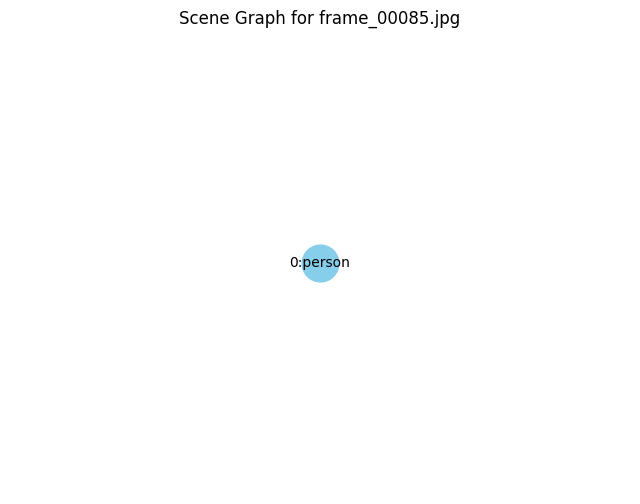

Scene Graph for frame_00090.jpg


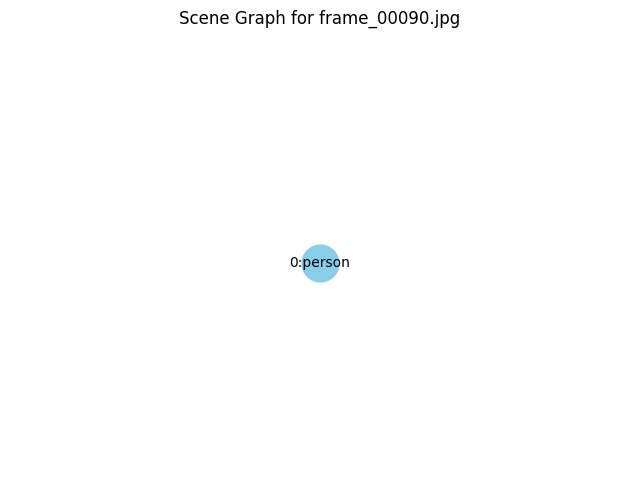

Scene Graph for frame_00095.jpg


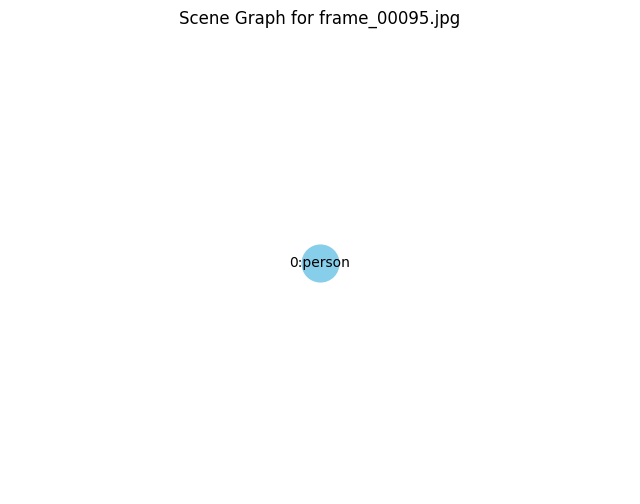

Scene Graph for frame_00100.jpg


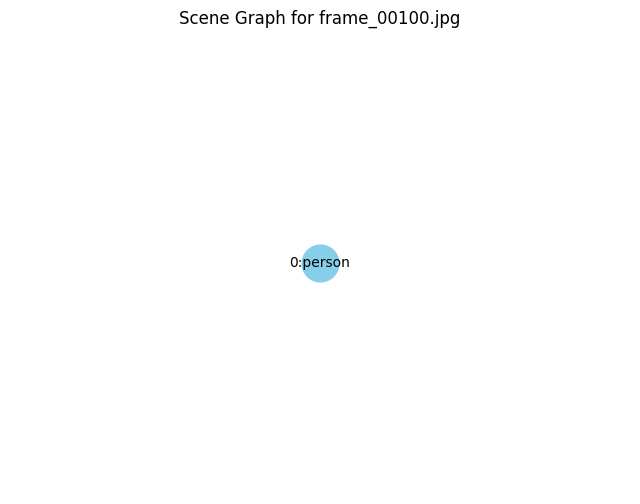

Scene Graph for frame_00105.jpg


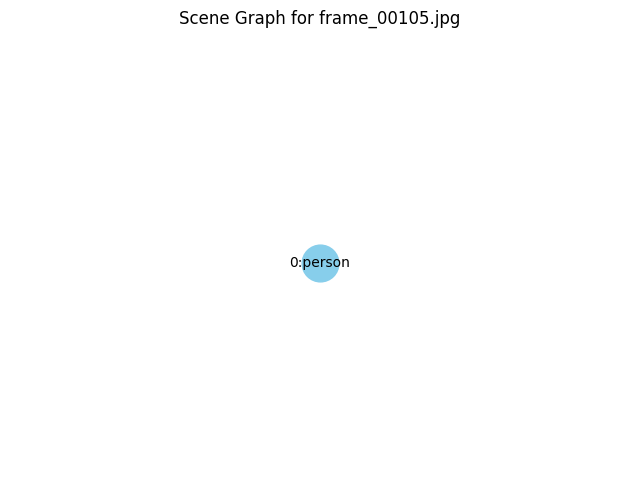

Scene Graph for frame_00110.jpg


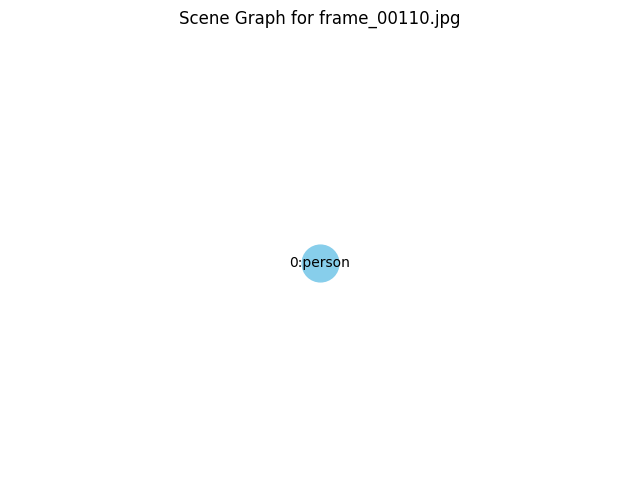

Scene Graph for frame_00115.jpg


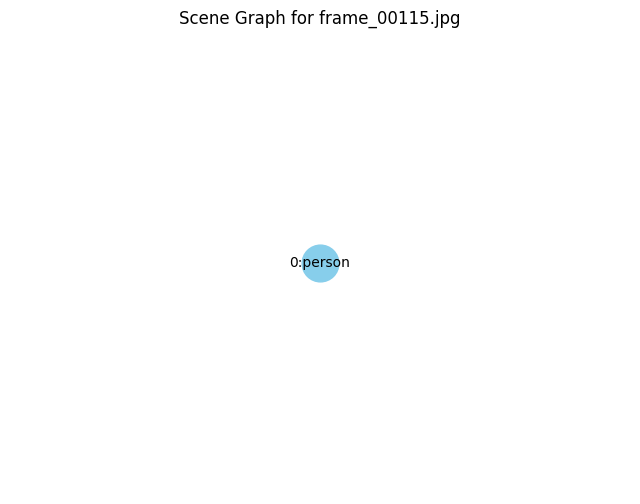

Scene Graph for frame_00120.jpg


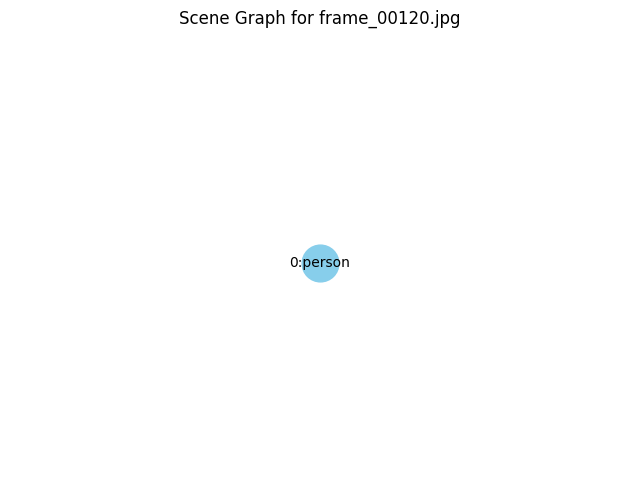

Scene Graph for frame_00125.jpg


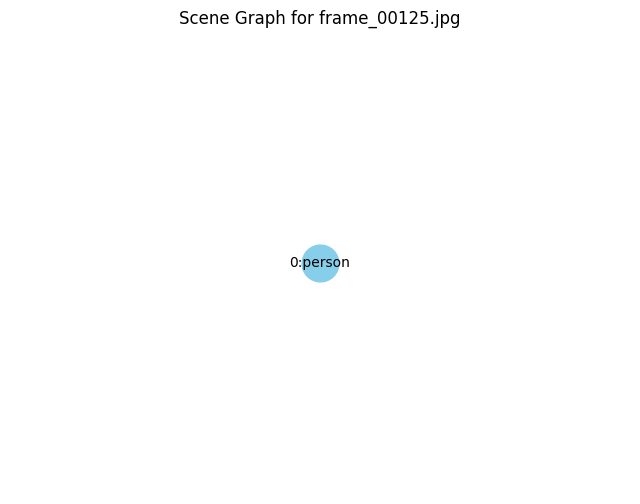

Scene Graph for frame_00130.jpg


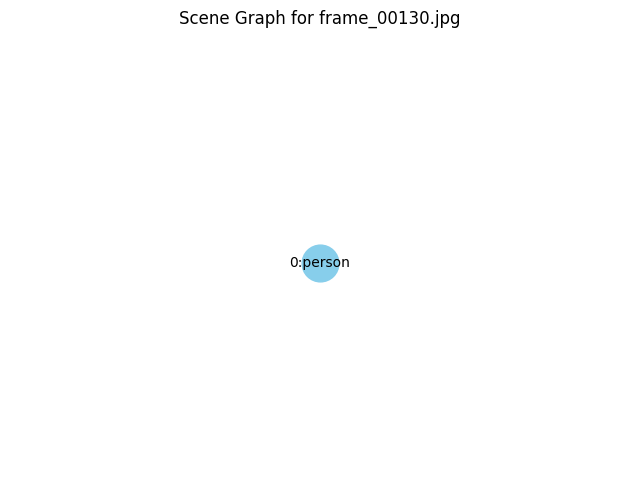

Scene Graph for frame_00135.jpg


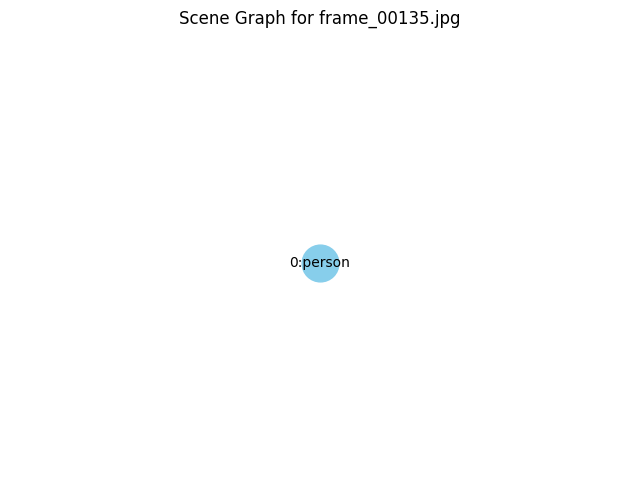

Scene Graph for frame_00140.jpg


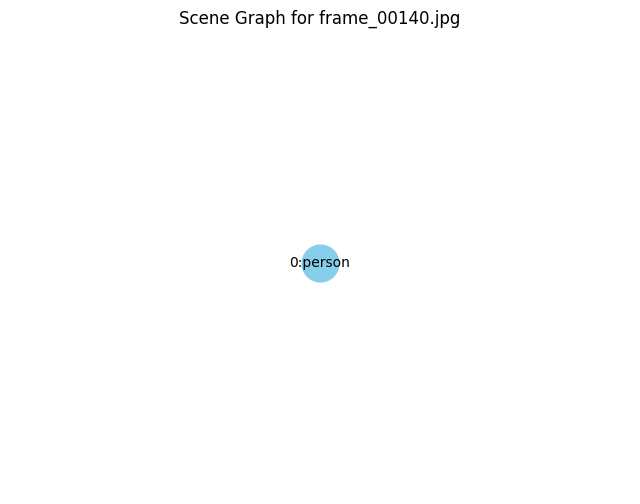

Scene Graph for frame_00145.jpg


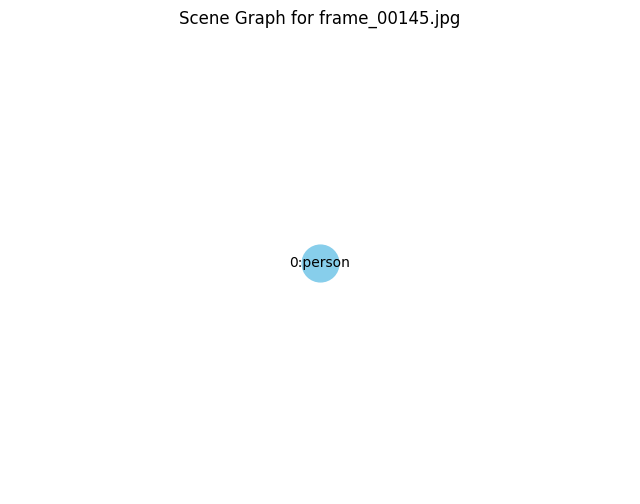

Scene Graph for frame_00150.jpg


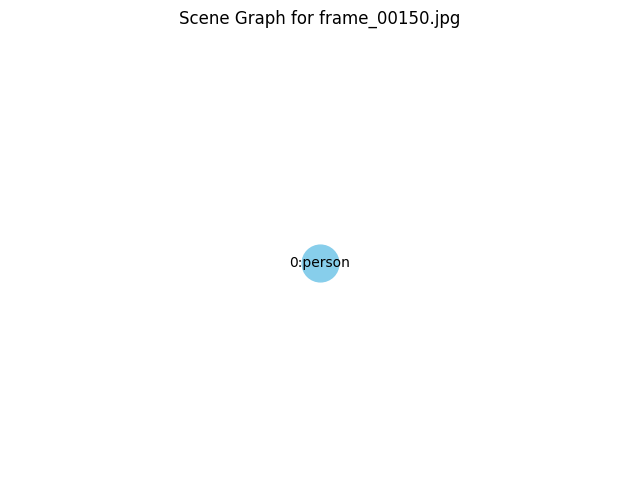

Scene Graph for frame_00155.jpg


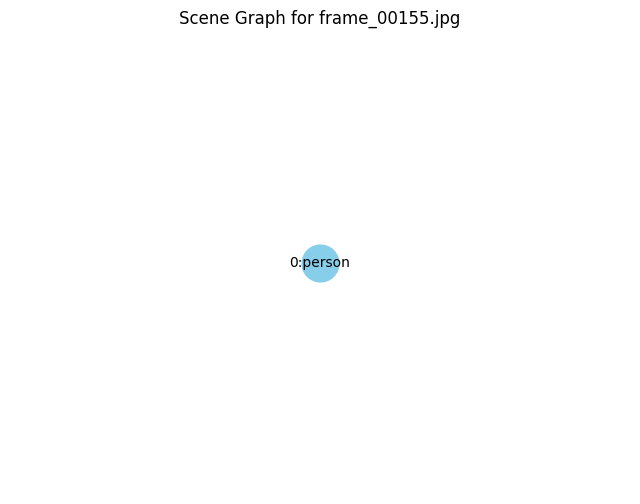

Scene Graph for frame_00160.jpg


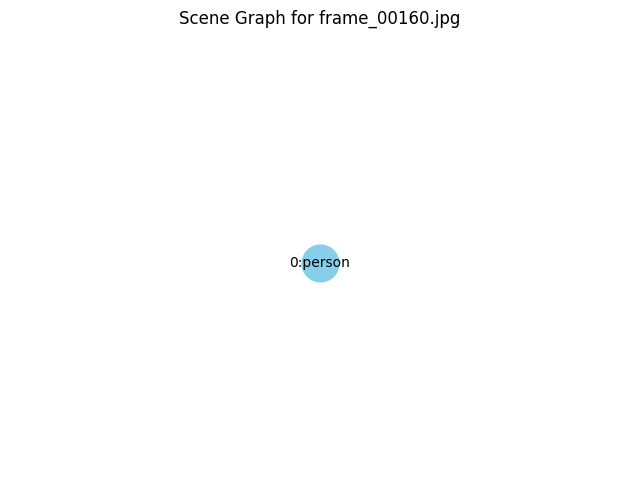

Scene Graph for frame_00165.jpg


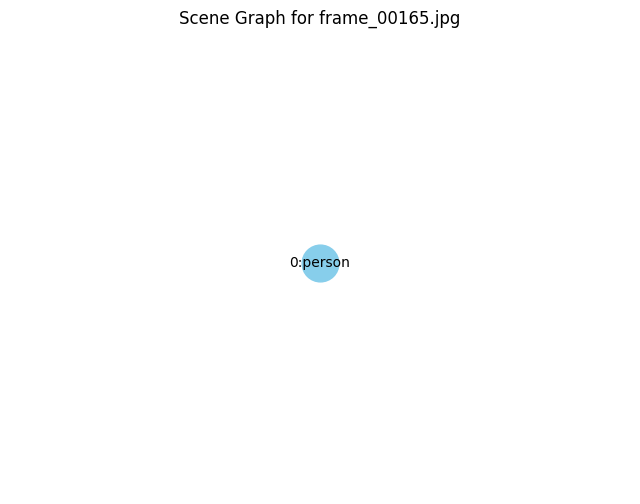

Scene Graph for frame_00170.jpg


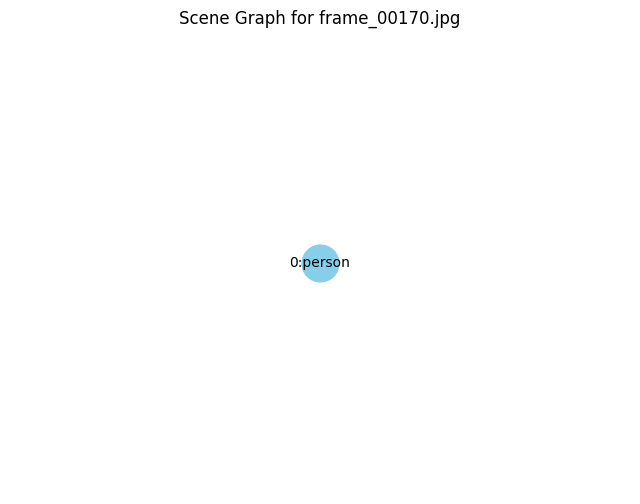

Scene Graph for frame_00175.jpg


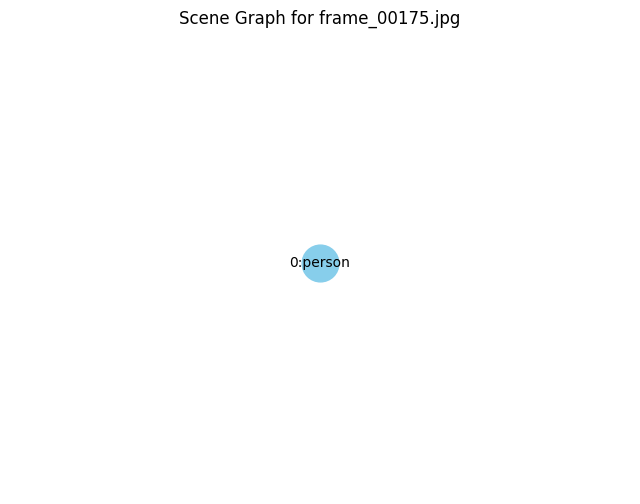

Scene Graph for frame_00180.jpg


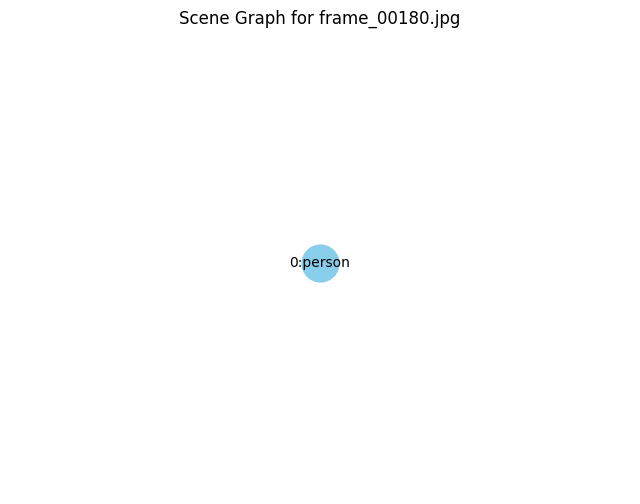

Scene Graph for frame_00185.jpg


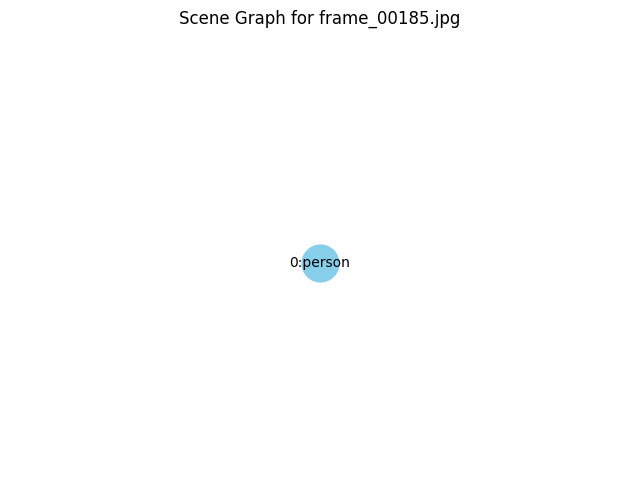

Scene Graph for frame_00190.jpg


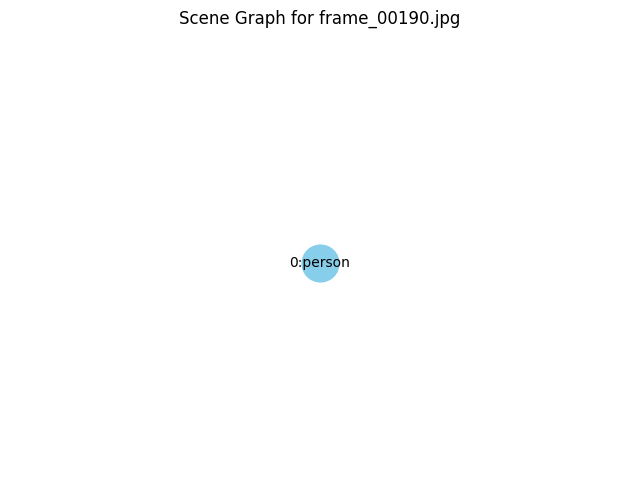

Scene Graph for frame_00195.jpg


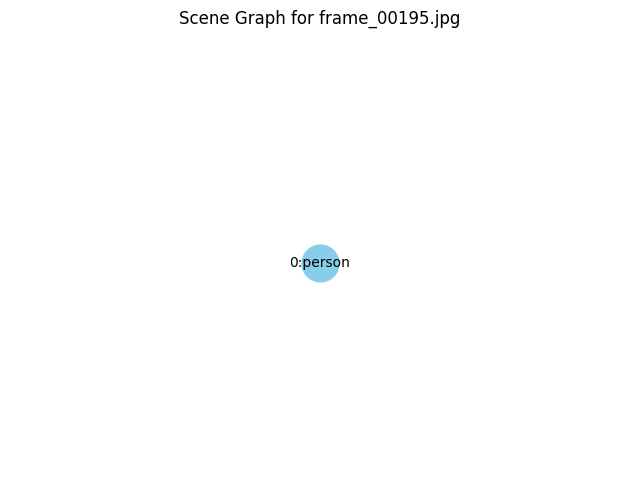

Scene Graph for frame_00200.jpg


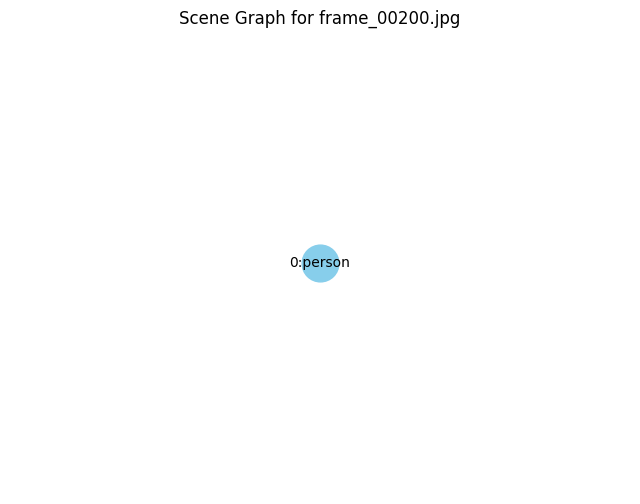

Scene Graph for frame_00205.jpg


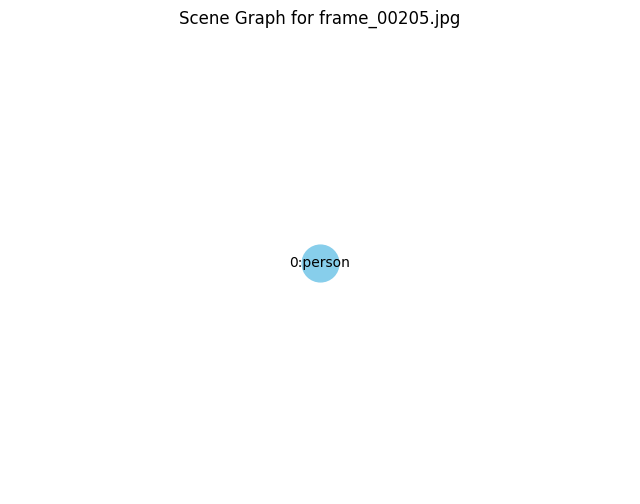

Scene Graph for frame_00210.jpg


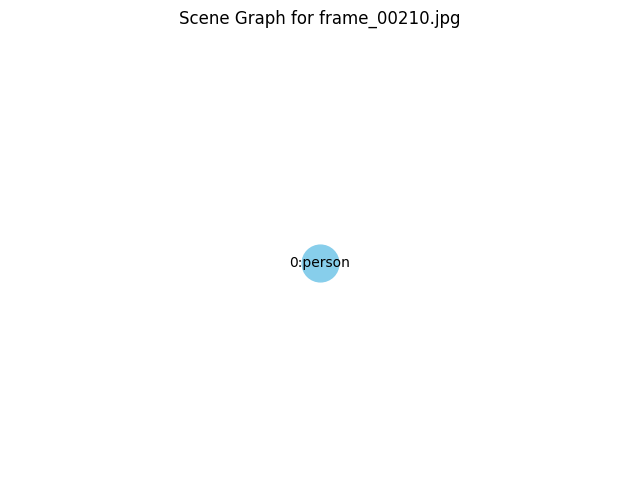

Scene Graph for frame_00215.jpg


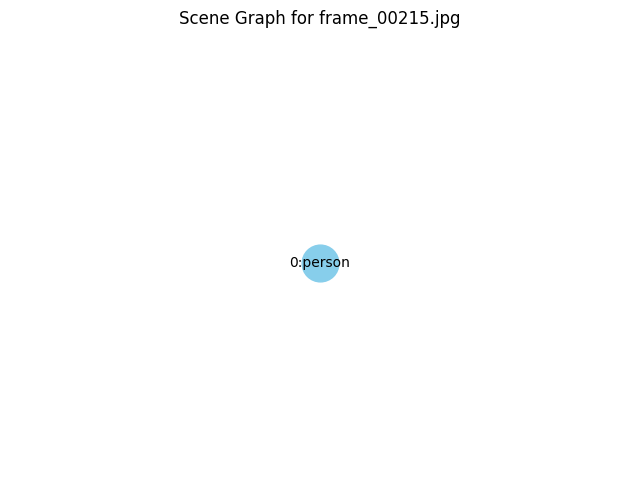

Scene Graph for frame_00220.jpg


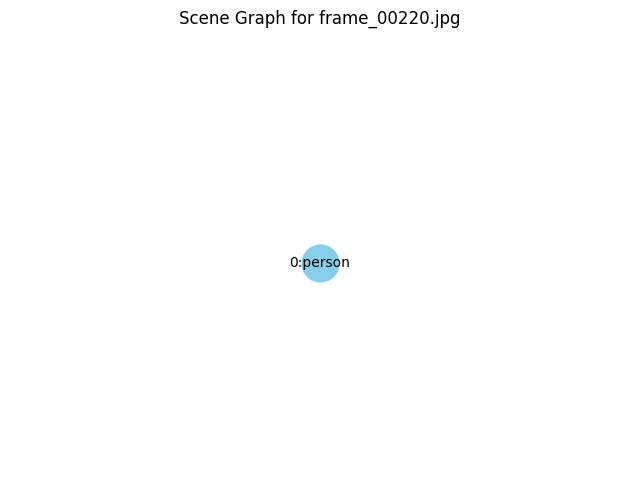

Scene Graph for frame_00225.jpg


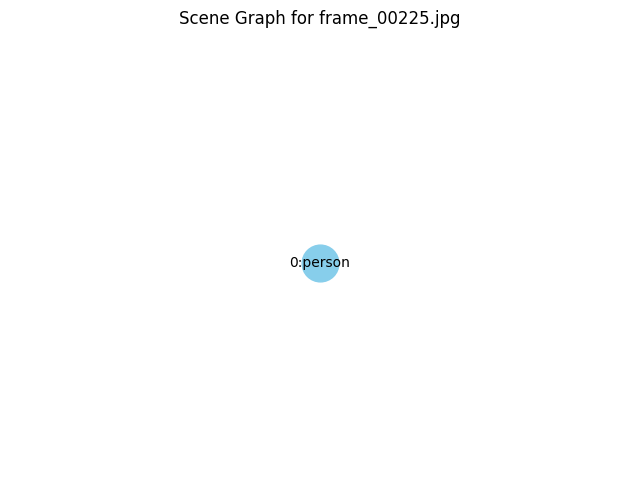

Scene Graph for frame_00230.jpg


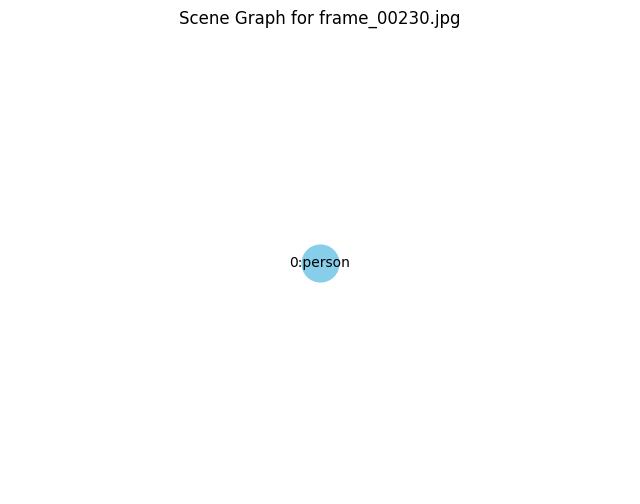

Scene Graph for frame_00235.jpg


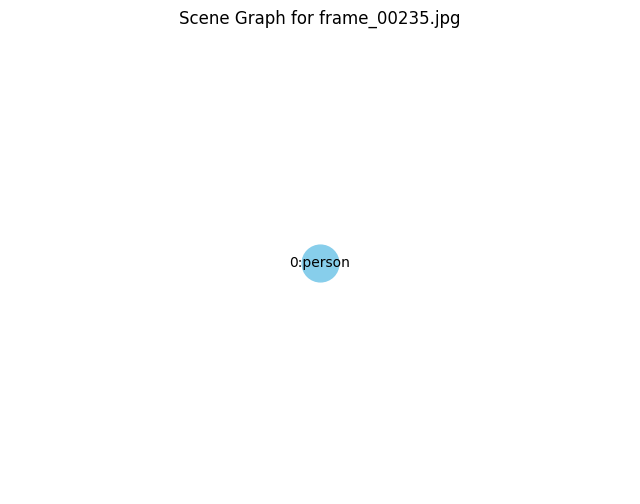

Scene Graph for frame_00240.jpg


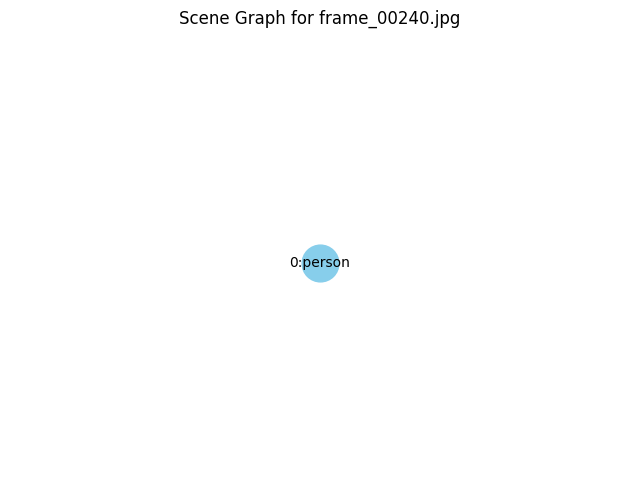

Scene Graph for frame_00245.jpg


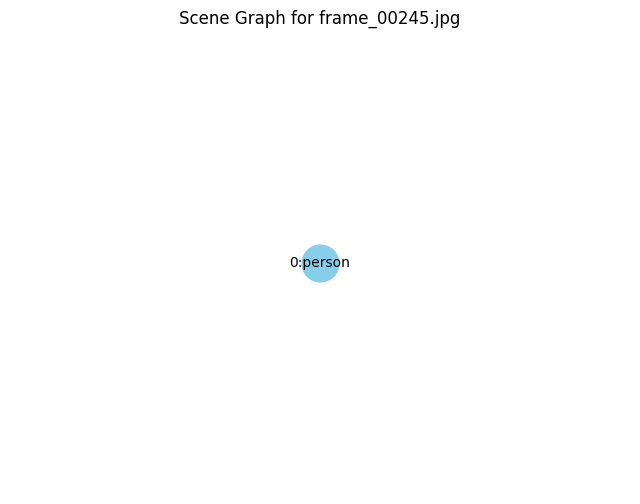

Scene Graph for frame_00250.jpg


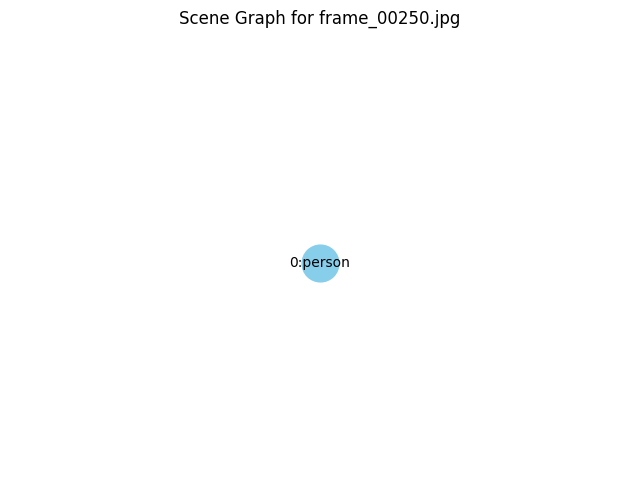

Scene Graph for frame_00255.jpg


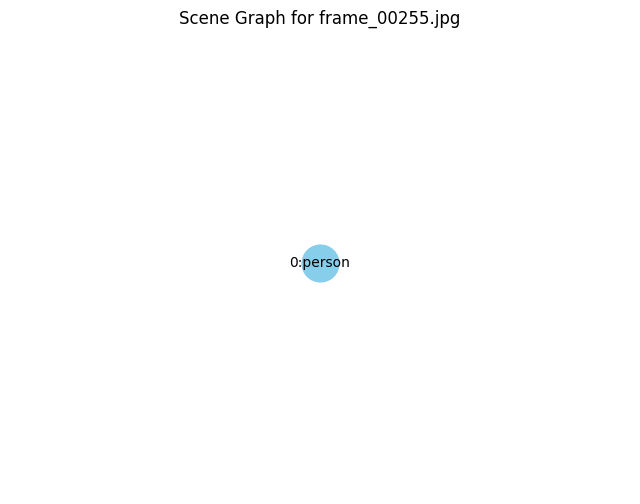

Scene Graph for frame_00260.jpg


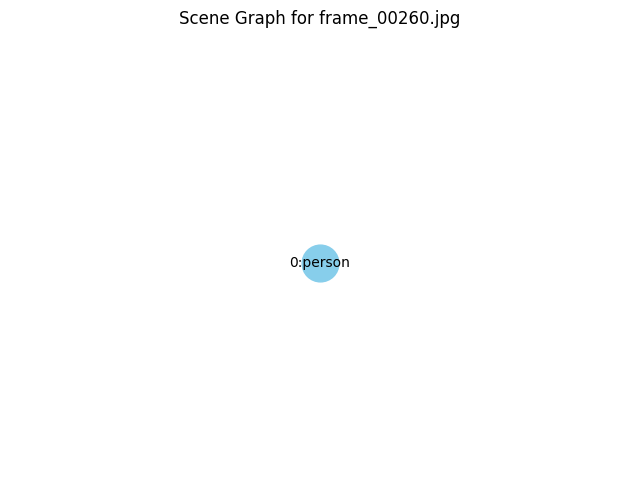

Scene Graph for frame_00265.jpg


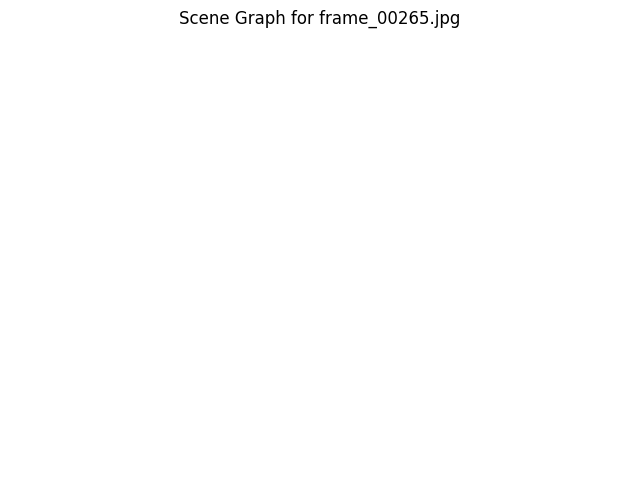

Scene Graph for frame_00270.jpg


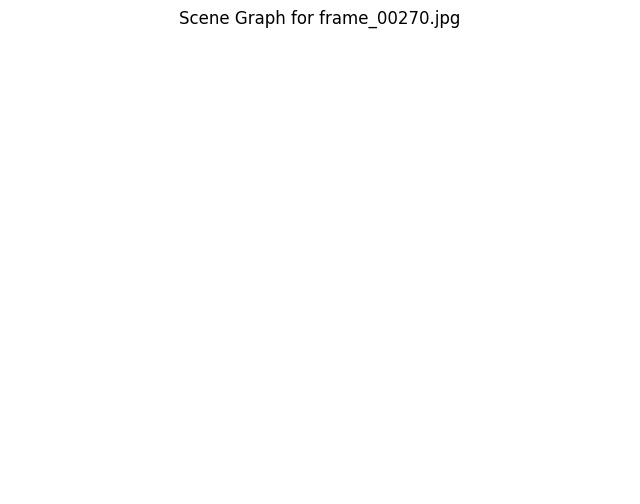

Scene Graph for frame_00275.jpg


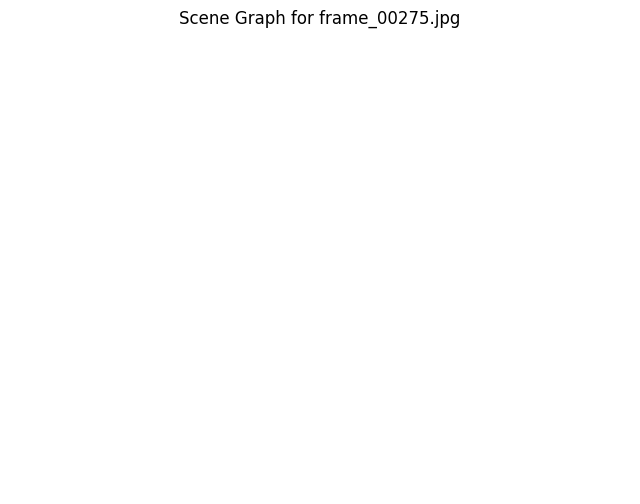

Scene Graph for frame_00280.jpg


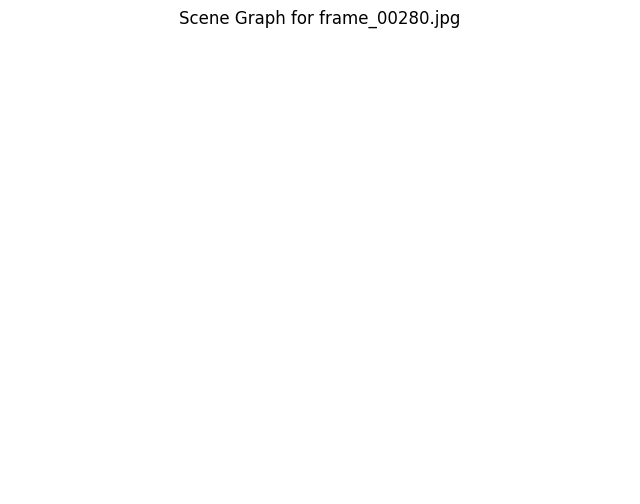

Scene Graph for frame_00285.jpg


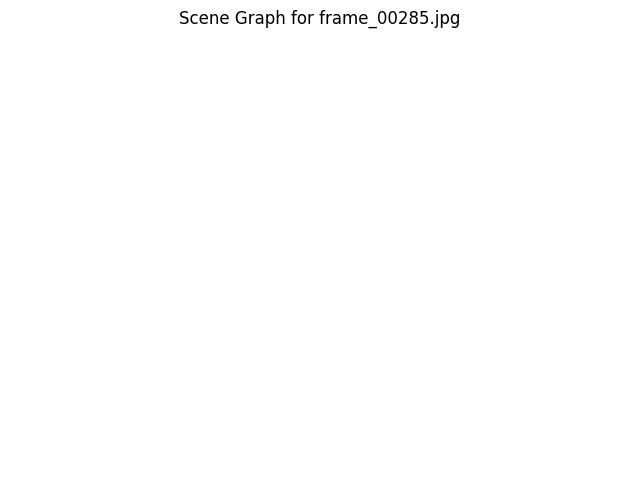

Scene Graph for frame_00290.jpg


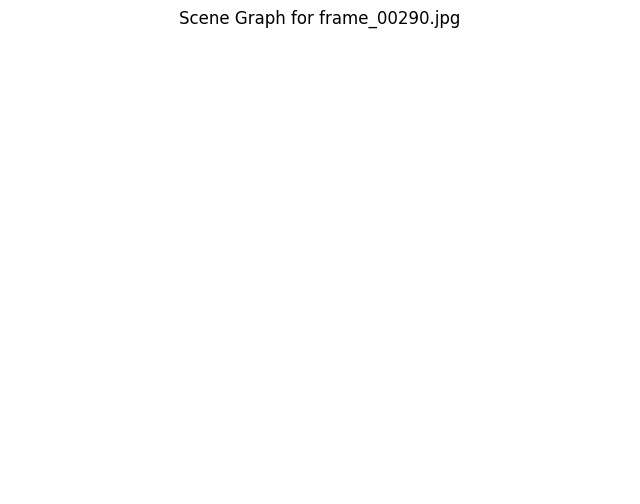

Scene Graph for frame_00295.jpg


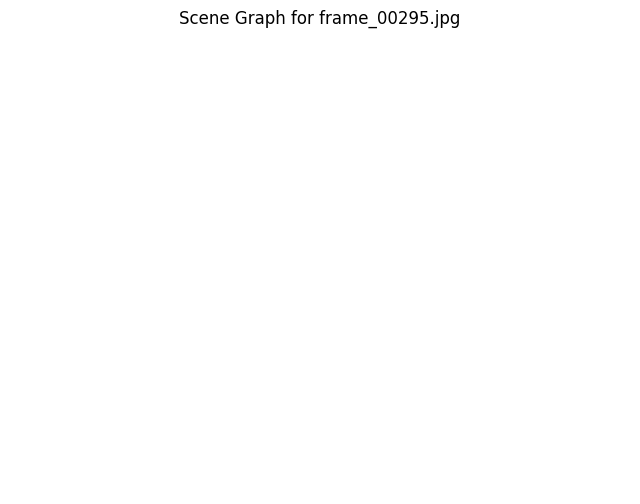

Scene Graph for frame_00300.jpg


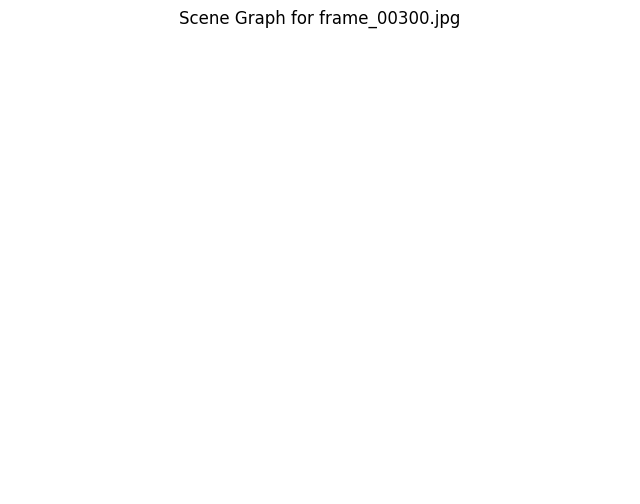

Scene Graph for frame_00305.jpg


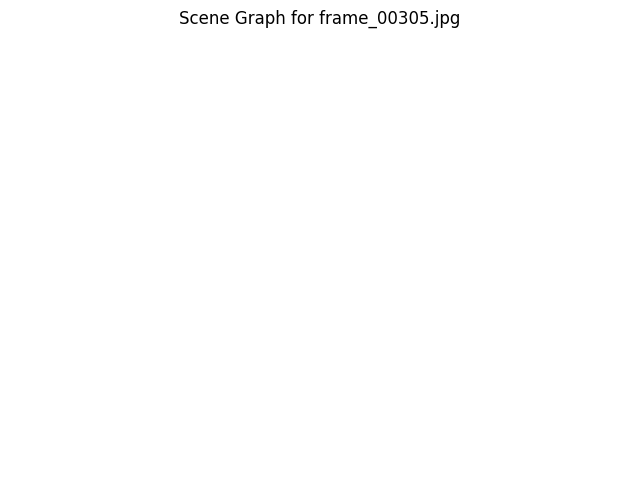

Scene Graph for frame_00310.jpg


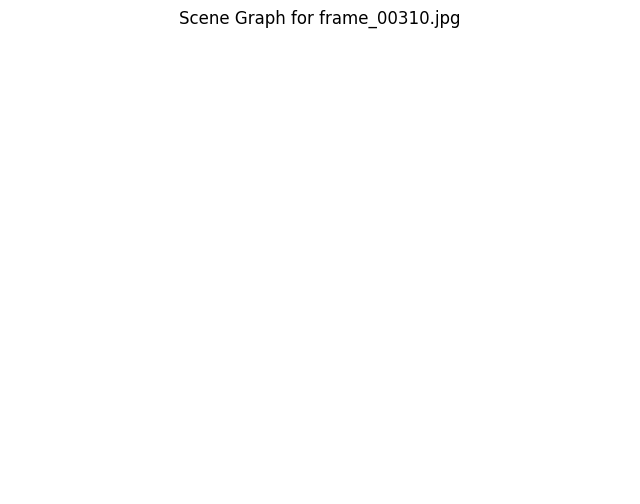

Scene Graph for frame_00315.jpg


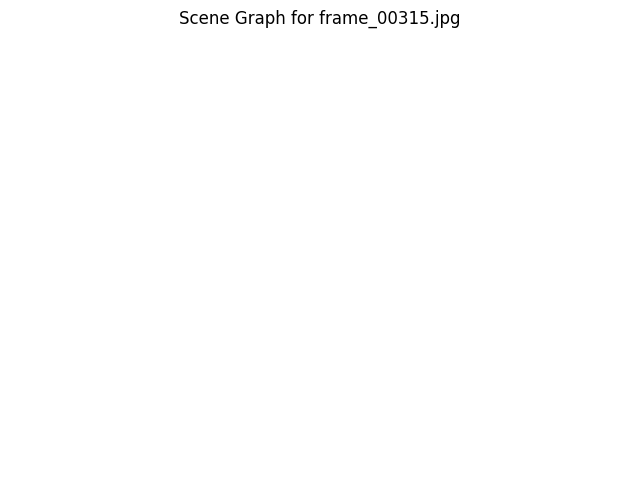

Scene Graph for frame_00320.jpg


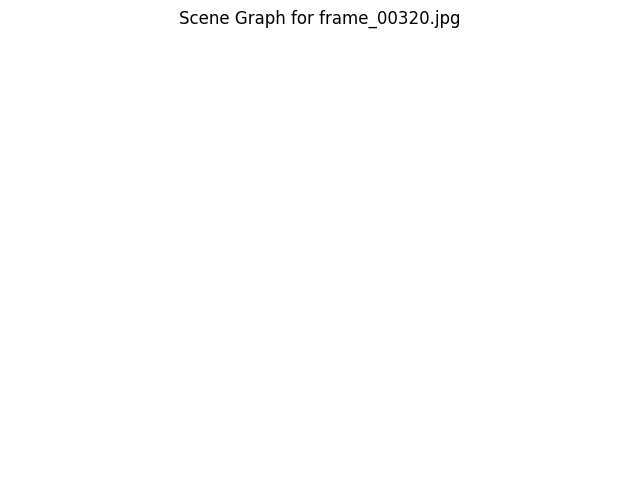

Scene Graph for frame_00325.jpg


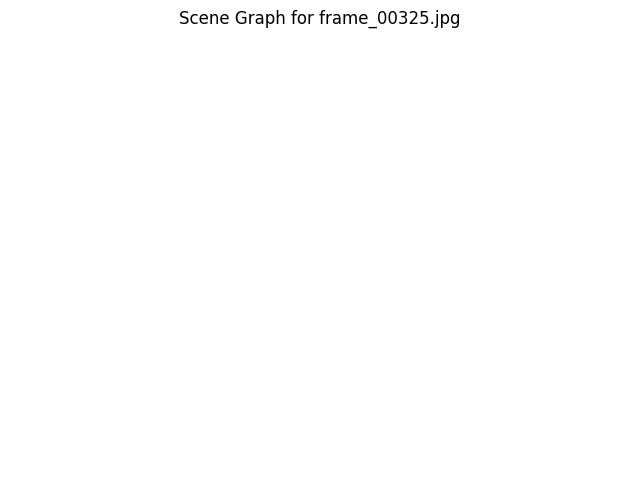

Scene Graph for frame_00330.jpg


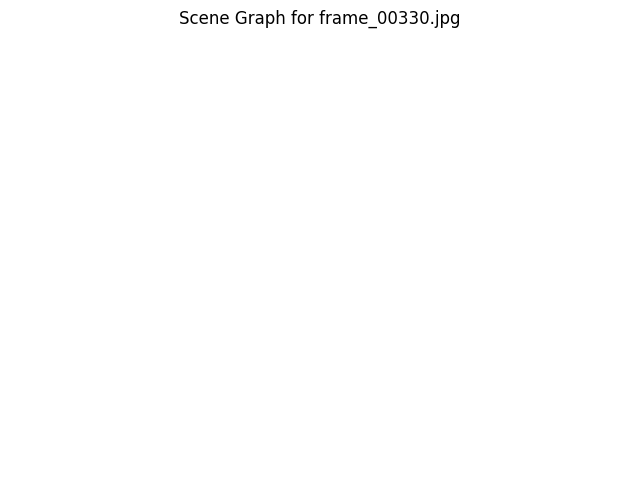

Scene Graph for frame_00335.jpg


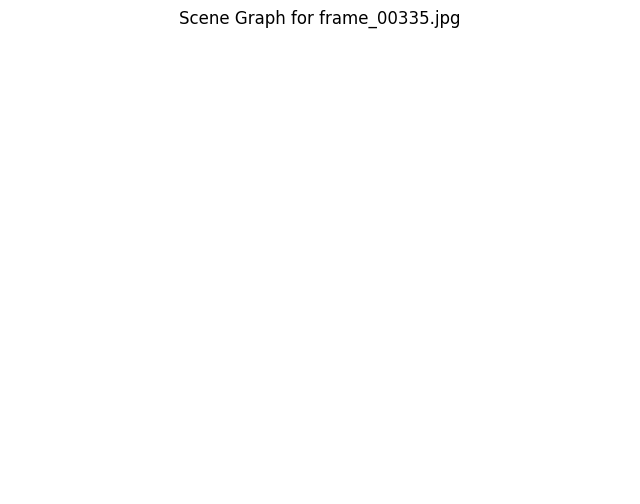

Scene Graph for frame_00340.jpg


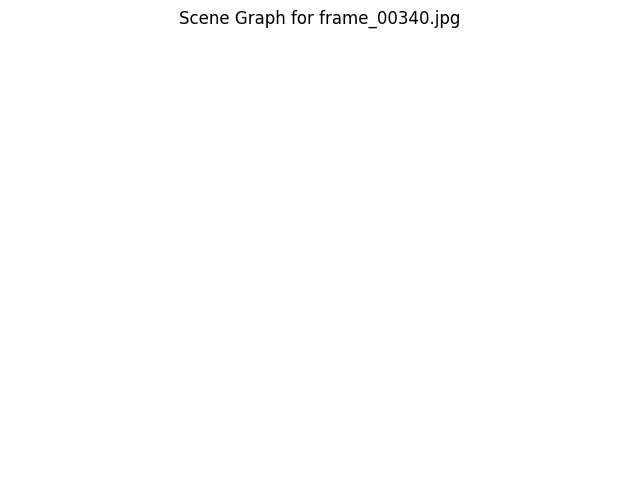

Scene Graph for frame_00345.jpg


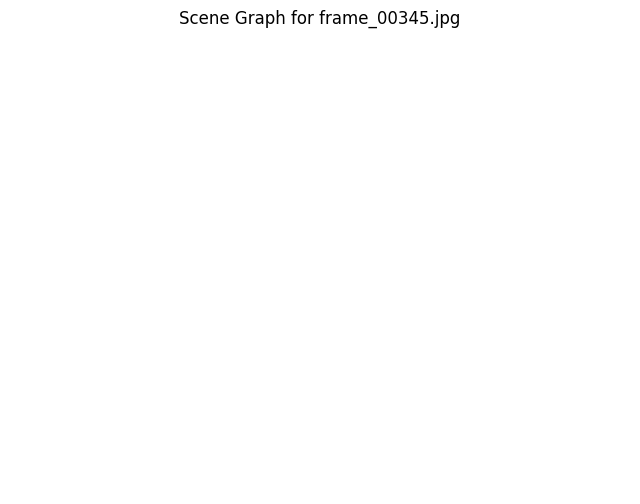

Scene Graph for frame_00350.jpg


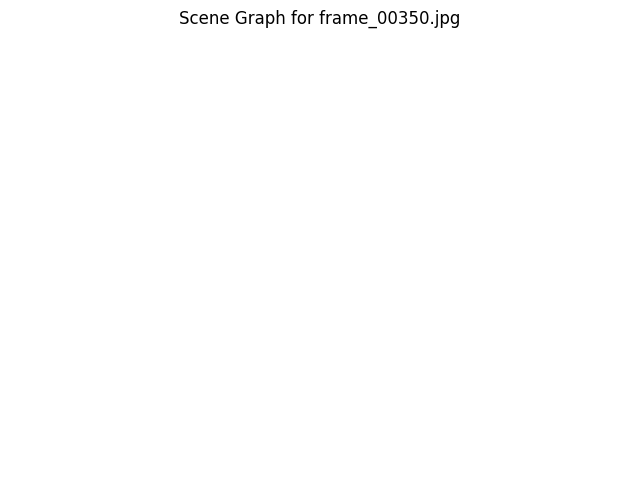

Scene Graph for frame_00355.jpg


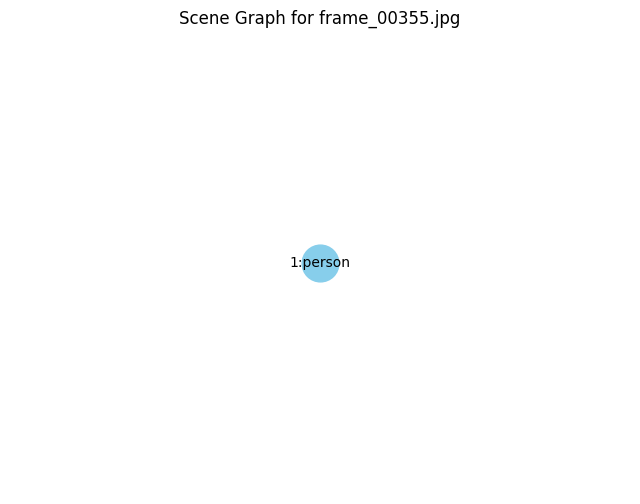

Scene Graph for frame_00360.jpg


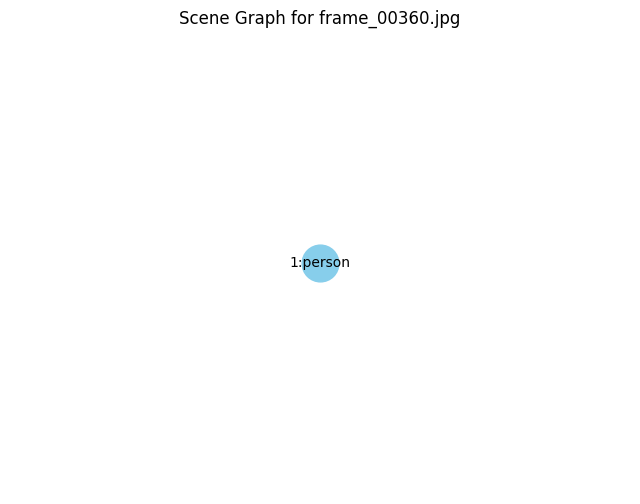

Scene Graph for frame_00365.jpg


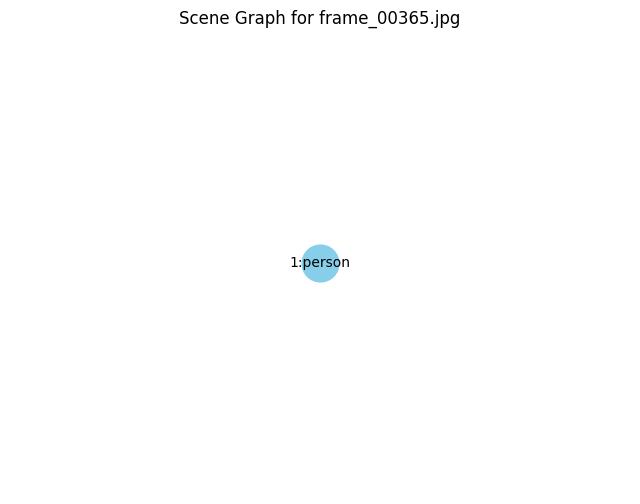

Scene Graph for frame_00370.jpg


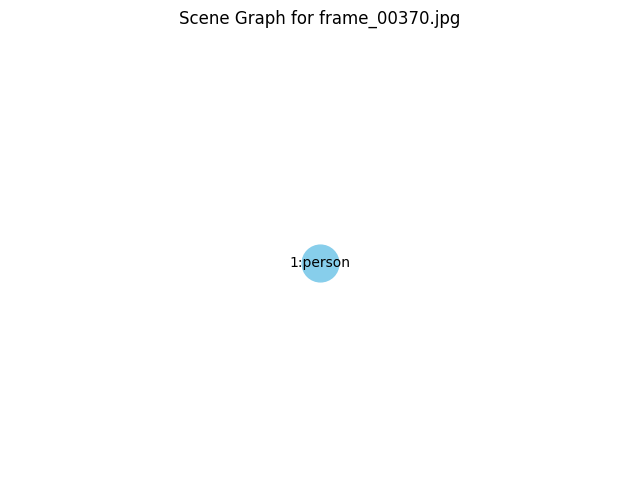

Scene Graph for frame_00375.jpg


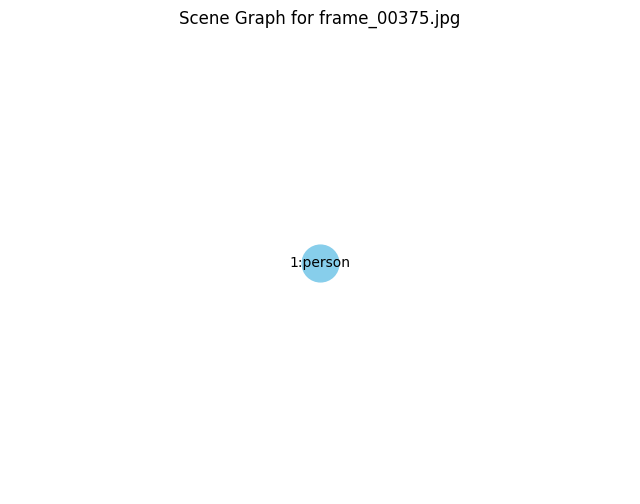

Scene Graph for frame_00380.jpg


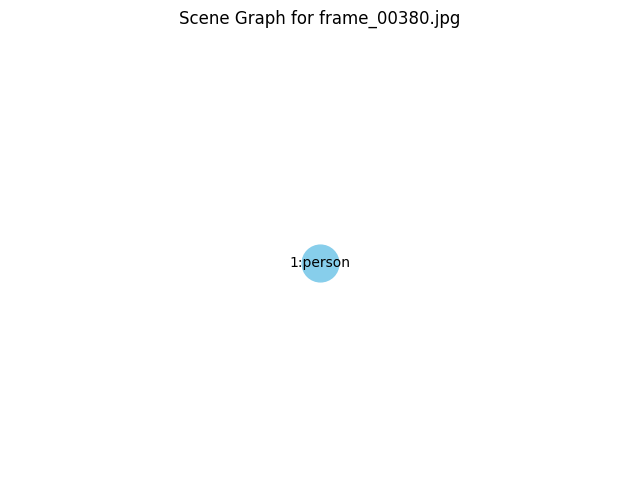

Scene Graph for frame_00385.jpg


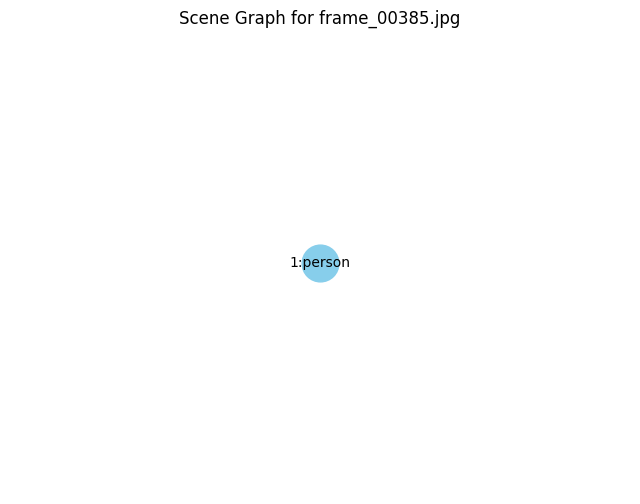

Scene Graph for frame_00390.jpg


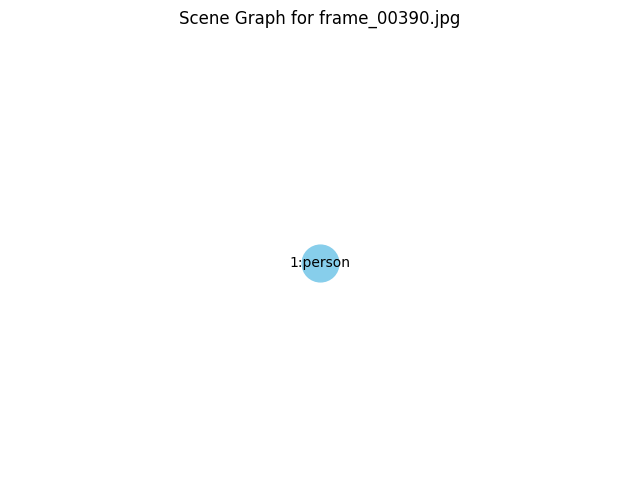

Scene Graph for frame_00395.jpg


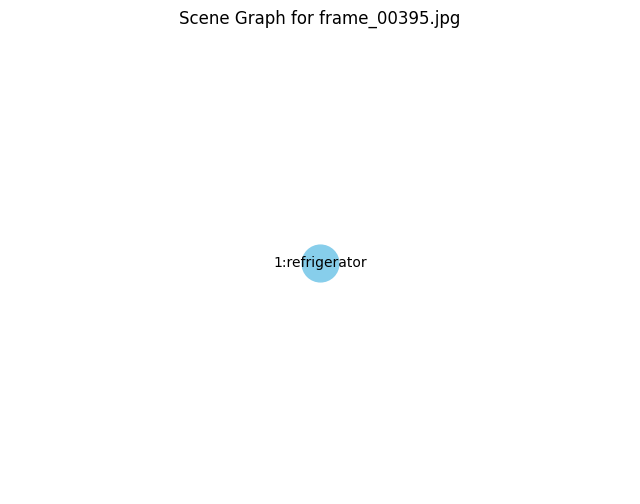

Scene Graph for frame_00400.jpg


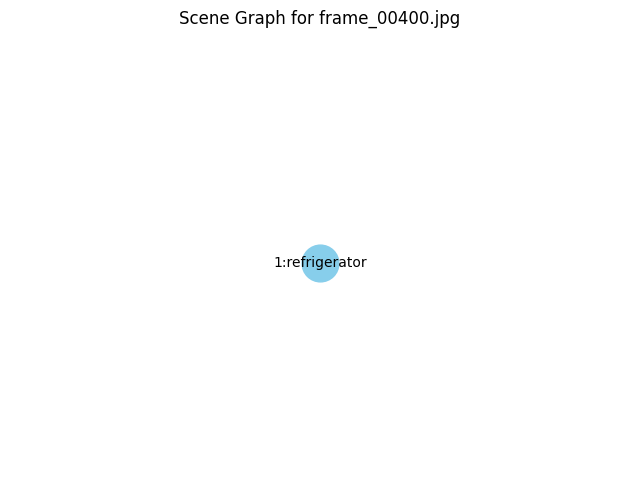

Scene Graph for frame_00405.jpg


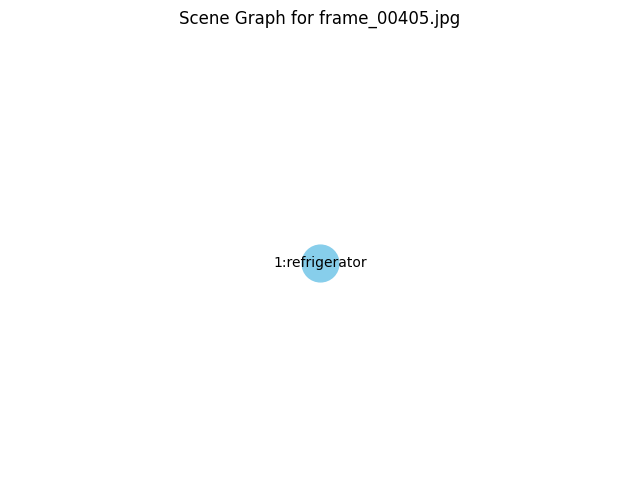

Scene Graph for frame_00410.jpg


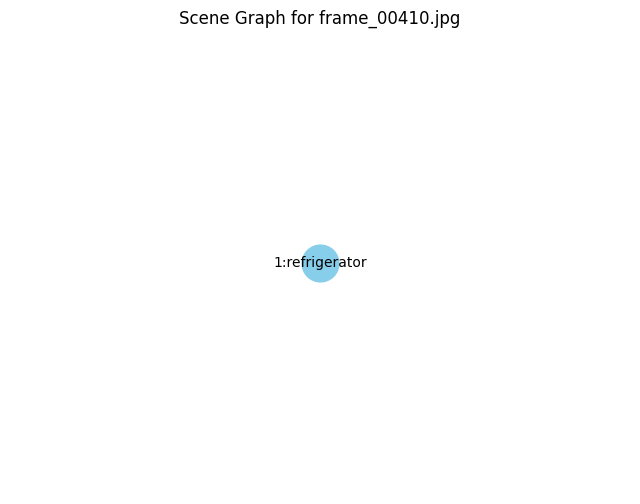

Scene Graph for frame_00415.jpg


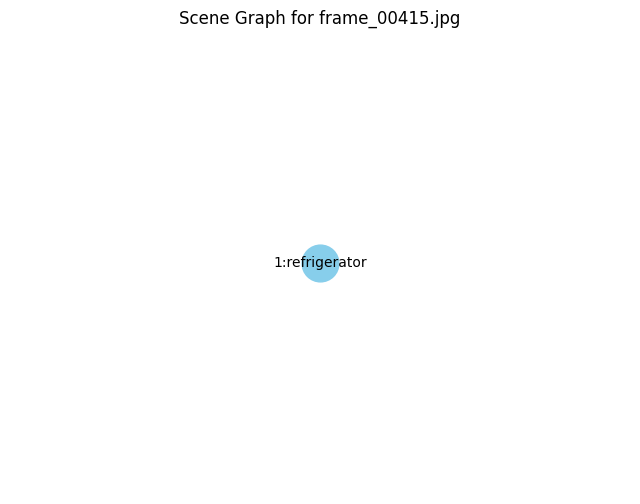

Scene Graph for frame_00420.jpg


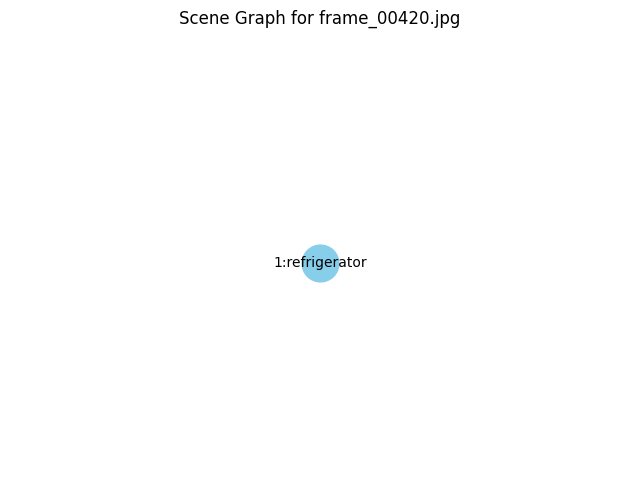

Scene Graph for frame_00425.jpg


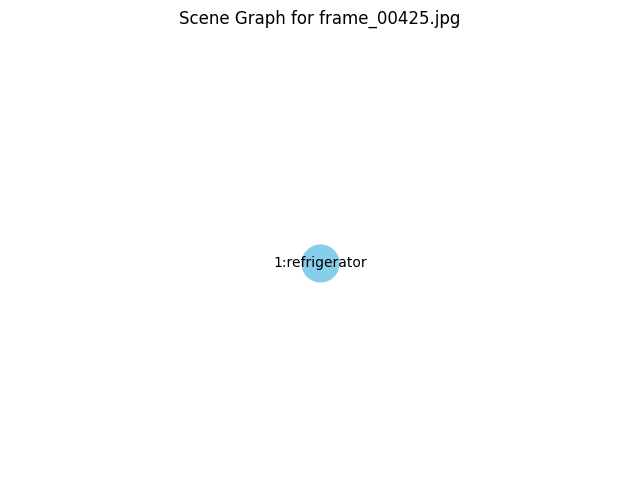

Scene Graph for frame_00430.jpg


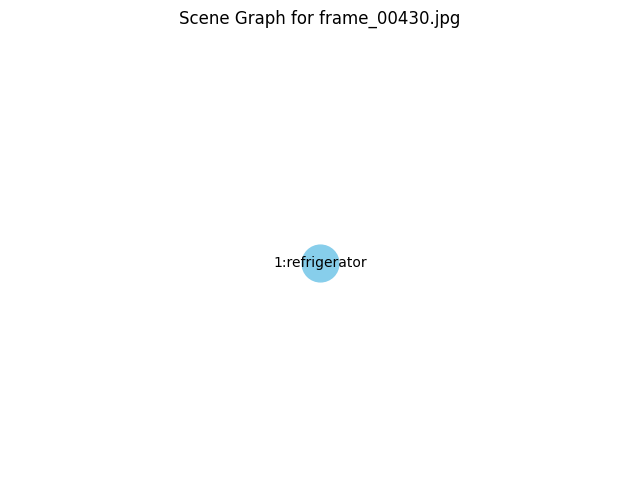

Scene Graph for frame_00435.jpg


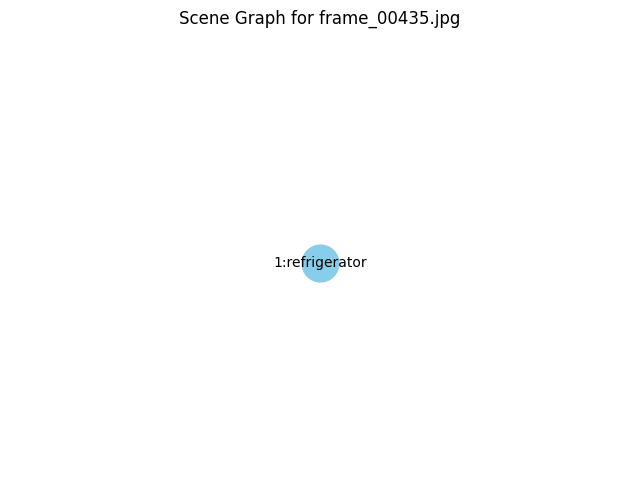

Scene Graph for frame_00440.jpg


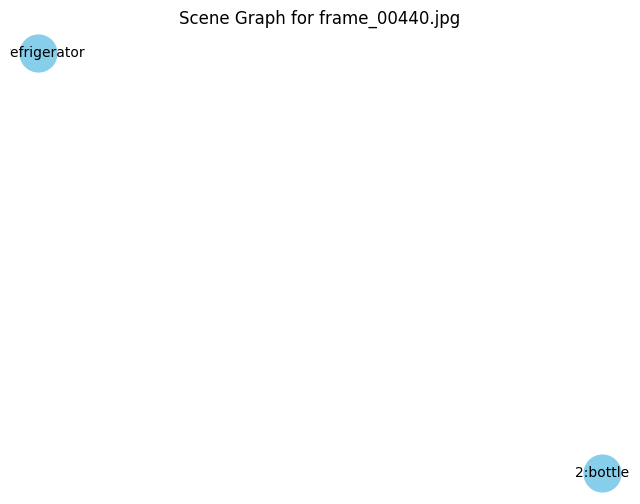

Scene Graph for frame_00445.jpg


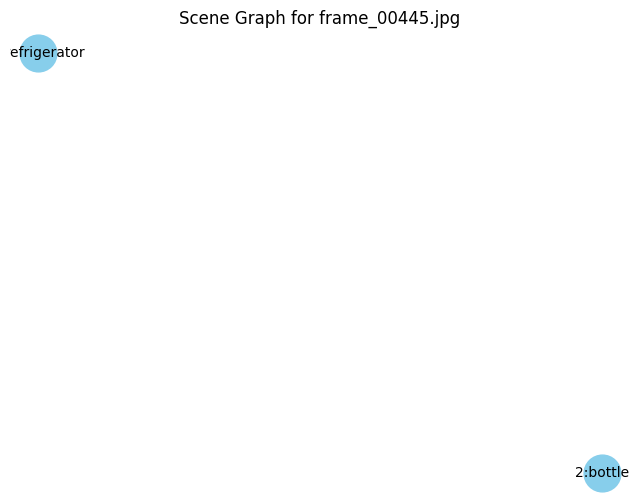

Scene Graph for frame_00450.jpg


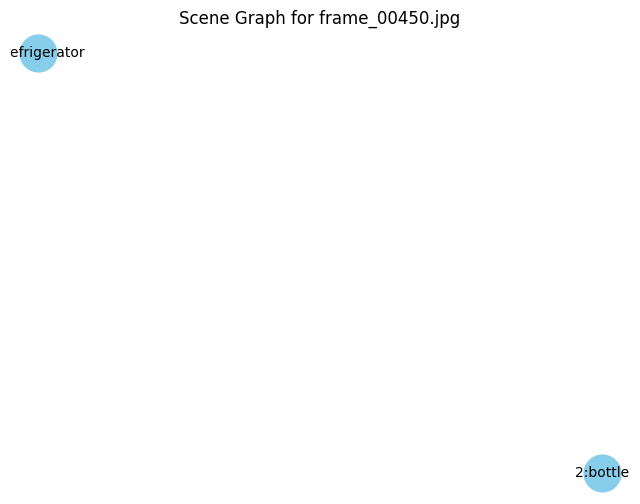

Scene Graph for frame_00455.jpg


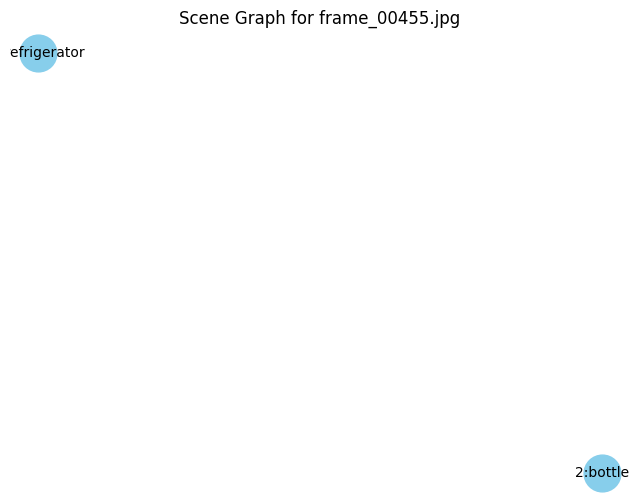

Scene Graph for frame_00460.jpg


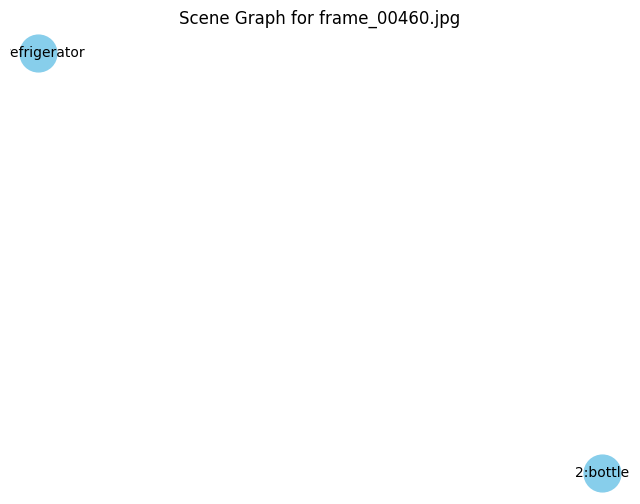

Scene Graph for frame_00465.jpg


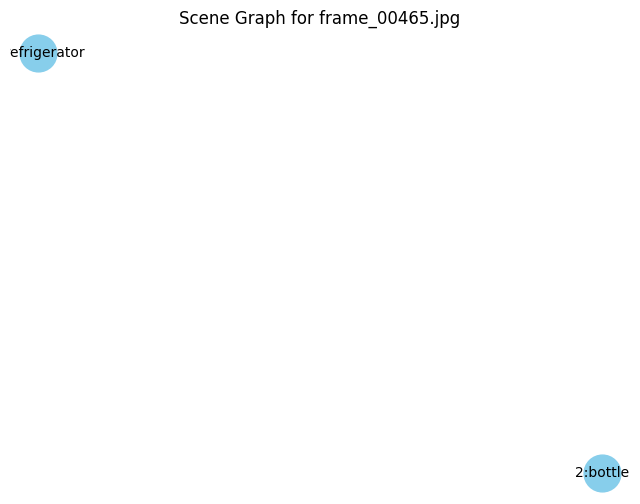

Scene Graph for frame_00470.jpg


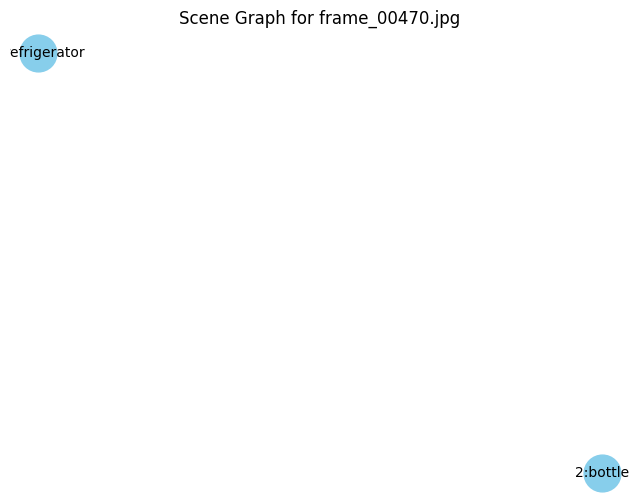

Scene Graph for frame_00475.jpg


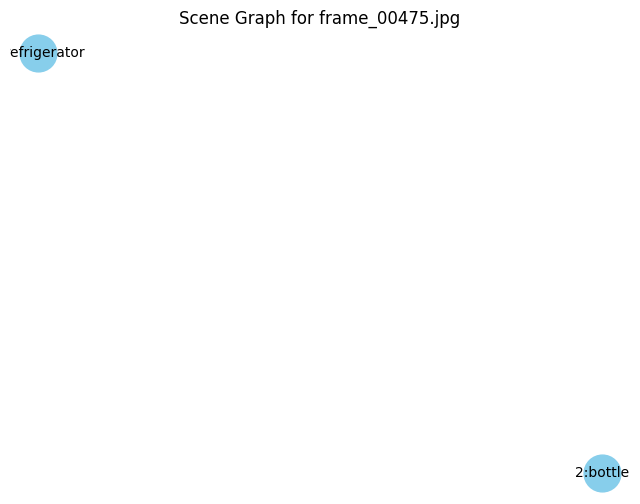

Scene Graph for frame_00480.jpg


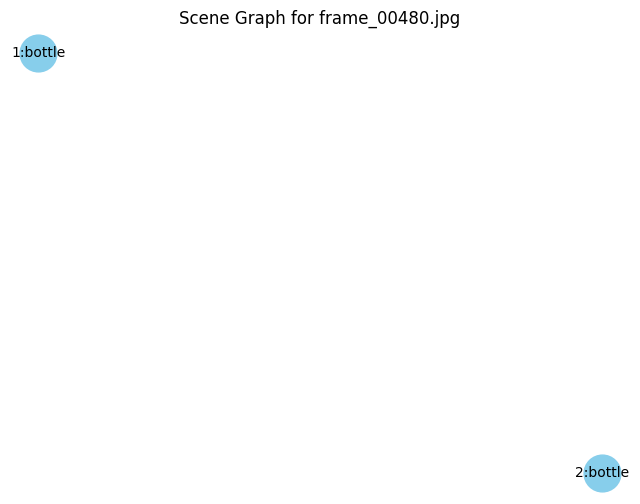

Scene Graph for frame_00485.jpg


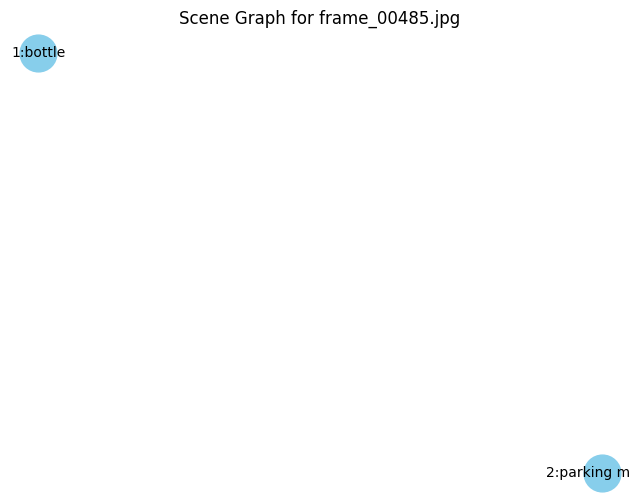

Scene Graph for frame_00490.jpg


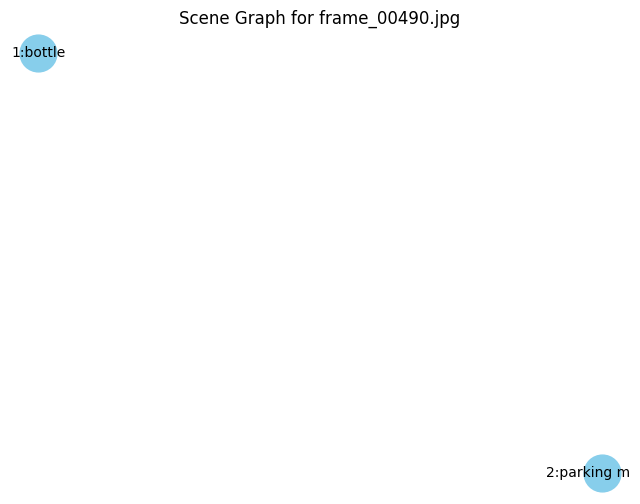

Scene Graph for frame_00495.jpg


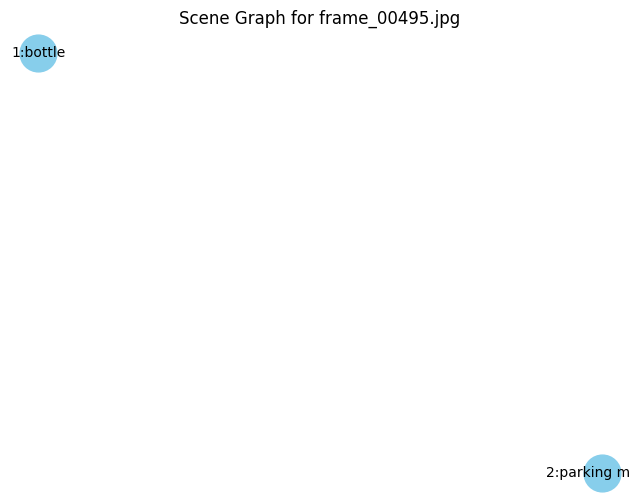

Scene Graph for frame_00500.jpg


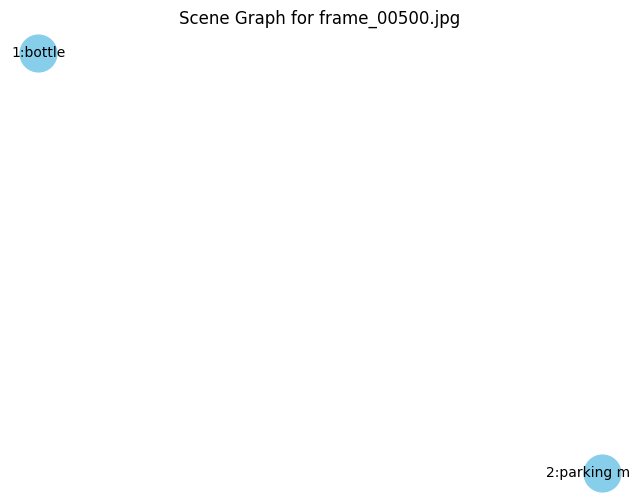

Scene Graph for frame_00505.jpg


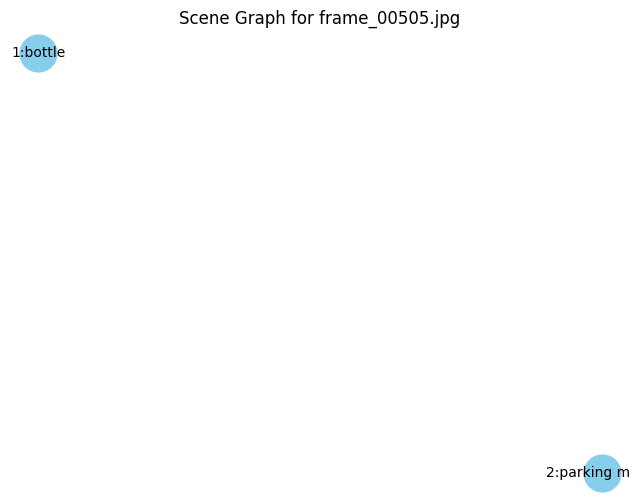

Scene Graph for frame_00510.jpg


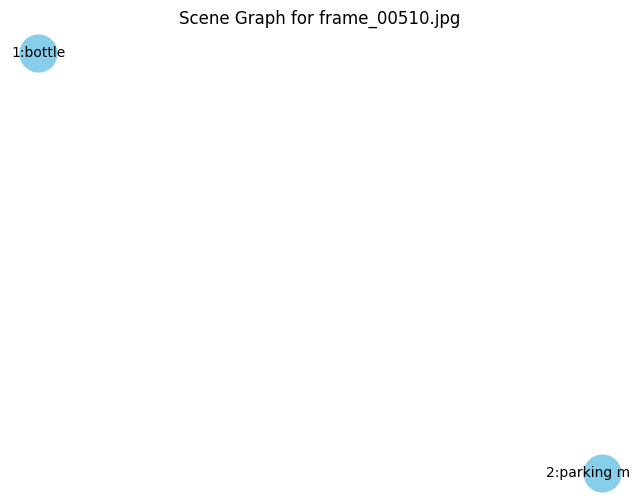

Scene Graph for frame_00515.jpg


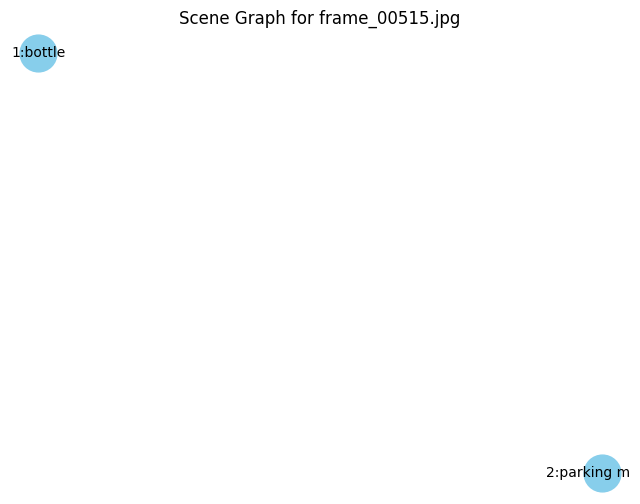

Scene Graph for frame_00520.jpg


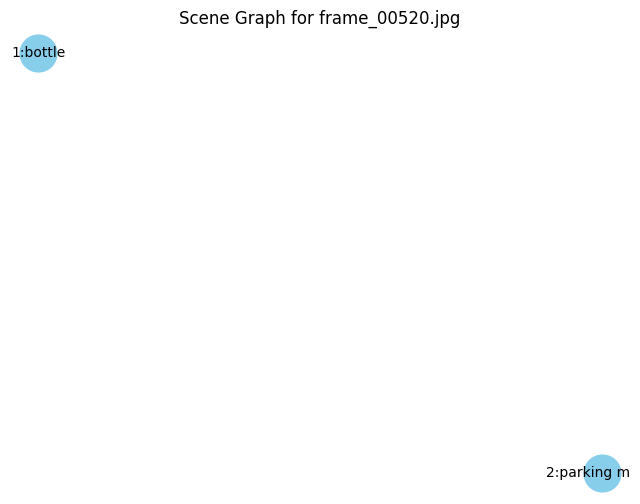

Scene Graph for frame_00525.jpg


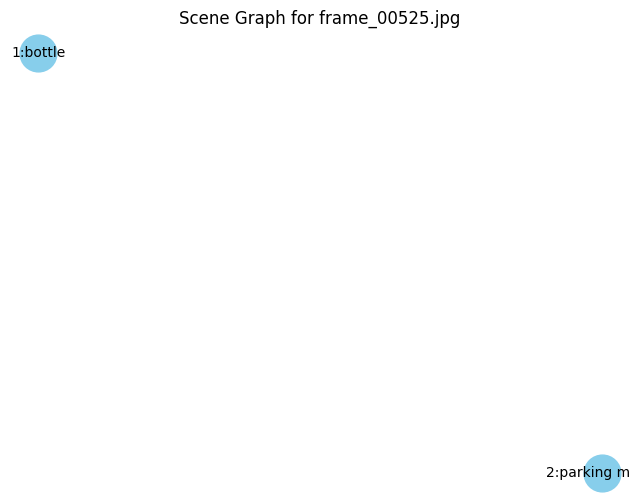

Scene Graph for frame_00530.jpg


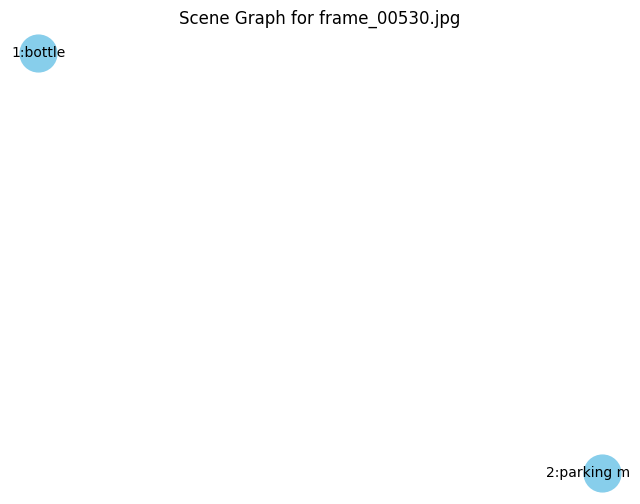

Scene Graph for frame_00535.jpg


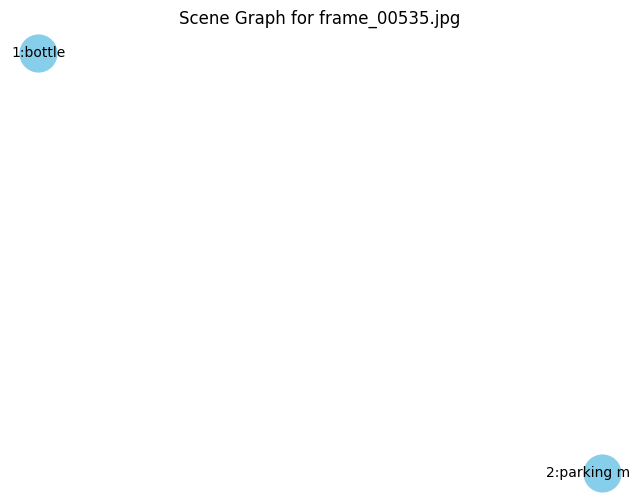

Scene Graph for frame_00540.jpg


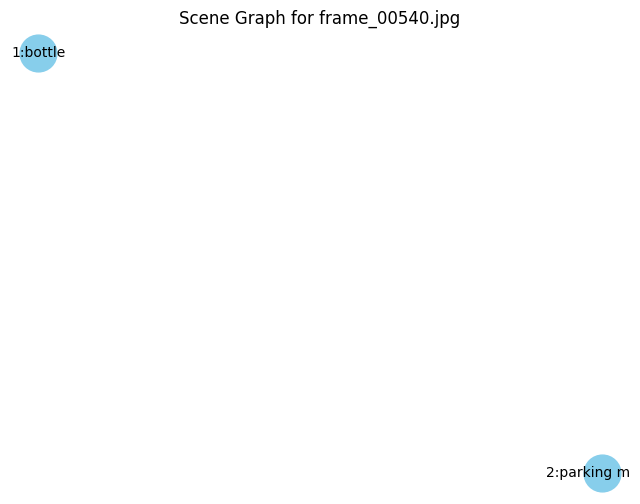

Scene Graph for frame_00545.jpg


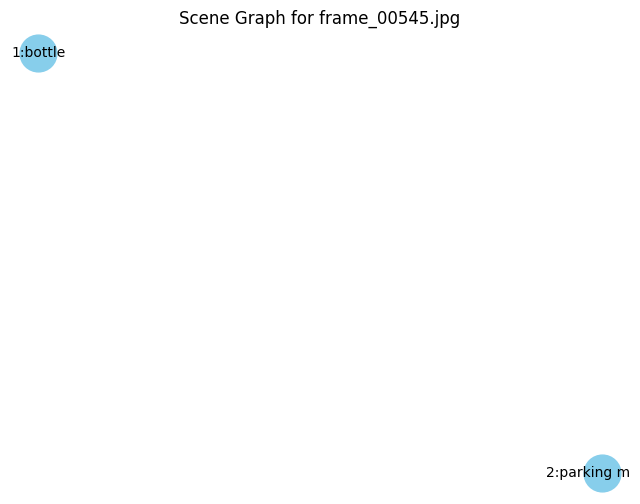

In [9]:
# Retrieve sorted list of frame image files
frame_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".jpg")])

# Dictionary to store scene graphs per frame.
scene_graphs = {}

# For aggregating objects over frames (using tracker IDs).
aggregated_objects = {}

# Process each frame sequentially.
for frame_file in frame_files:
    frame_path = os.path.join(FRAMES_DIR, frame_file)
    image = cv2.imread(frame_path)
    if image is None:
        continue
    
    # Run YOLO detection on the frame.
    boxes, labels = detect_objects(image)
    detections = list(zip(boxes, labels))
    
    # Update the tracker. The tracker returns a dict of objects keyed by unique IDs.
    tracked_objects = tracker.update(detections)
    
    # Prepare a list of objects (with an explicit "id" key) for relationship detection.
    objects_list = []
    for obj_id, info in tracked_objects.items():
        temp = info.copy()
        temp["id"] = obj_id
        objects_list.append(temp)
        
        # Aggregate tracked objects over all frames.
        aggregated_objects[obj_id] = info  # In a more advanced system, you would combine attributes temporally.
    
    # Detect relationships between objects.
    relationships = detect_relationships(objects_list, distance_threshold=100)
    
    # Build a scene graph for the current frame.
    G = build_scene_graph(tracked_objects, relationships)
    
    # Visualize the scene graph for the current frame.
    print(f"Scene Graph for {frame_file}")
    visualize_scene_graph(G, title=f"Scene Graph for {frame_file}")
    
    # Store the scene graph.
    scene_graphs[frame_file] = G

Temporal Aggregation & Final Visualization